# Проект: телекоммуникации

## Введение

_____
    
**Название проекта**

Телекоммуникации
_____
**Описание исследования.**

Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах. Задача — обучить на этих данных модель для прогноза оттока клиентов.

_____
**Цель исследования.**
    
Создание модели прогнозирования — для предсказания того, что клиент разорвёт договор.
И предоставление рекомендаций для бизнеса.
    
_____
**Задачи исследования.**

1. Загрузка и предобработка данных, проверка на наличие пропусков и ошибок.
2. Объединение данных.
3. Проведение исследовательского анализа данных и построение визуализаций.
4. Создание новых признаков
5. Корреляционный анализ
6. Подготовка данных для обучения модели.
7. Обучение моделей машинного обучения
8. Выбор лучшей модель и проверка её качество
9. Анализ важности признаков и матрицы ошибок
10. Общий вывод и рекомендации заказчику
_____
**Исходные данные.**
    
1. contract_new.csv — информация о договоре.
2. personal_new.csv — персональные данные клиента.
3. internet_new.csv — информация об интернет-услугах.
4. phone_new.csv —  информация об услугах телефонии.
______

## Загрузка данных

___
    Импортируем все необходимые нам библиотеки
    И установим константные переменные
---

In [1]:
!pip install phik -q


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: C:\Users\koziy\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
import re
import numpy as np
import pandas as pd
import phik
import matplotlib.pyplot as plt
import seaborn as sns
import shap

# Визуализация
from phik.report import plot_correlation_matrix

# Импорты из sklearn
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    roc_auc_score,
)
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    MinMaxScaler,
    OneHotEncoder,
    OrdinalEncoder,
    RobustScaler,
    StandardScaler,
)

# Классификаторы
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier

# Градиентный бустинг
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier


plt.rcParams["figure.figsize"] = (9, 6)
RANDOM_STATE = 20625  # по условию
TEST_SIZE = 0.25      # по условию

___
    Загрузим данные
    Проект сохранён на kaggle, в случае, если проект запускают из другого источника, 
    то данные будут загружены с хранилища s3 Яндекса
___

In [3]:
try:
    df_contract = pd.read_csv("/kaggle/input/yp-final/contract_new.csv")
    df_internet = pd.read_csv("/kaggle/input/yp-final/internet_new.csv")
    df_personal = pd.read_csv("/kaggle/input/yp-final/personal_new.csv")
    df_phone = pd.read_csv("/kaggle/input/yp-final/phone_new.csv")

except:
    df_contract = pd.read_csv("https://code.s3.yandex.net/datasets/contract_new.csv")
    df_internet = pd.read_csv("https://code.s3.yandex.net/datasets/internet_new.csv")
    df_personal = pd.read_csv("https://code.s3.yandex.net/datasets/personal_new.csv")
    df_phone = pd.read_csv("https://code.s3.yandex.net/datasets/phone_new.csv")

---
    Изучим предоставленные данные
---

In [4]:
df_contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


In [5]:
df_internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [6]:
df_personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [7]:
df_phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [8]:
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [9]:
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [10]:
df_personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [11]:
df_phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


___ 
Обратимся к документации таблицы для определения значений столбцов:

**contract_new.csv**. Описание данных:

Таблица, которая содержит данные о договорах с клиентами, их условиях и расходах.

1.  customerID — идентификатор абонента.
2.  BeginDate — дата начала действия договора.
3.  EndDate — дата окончания действия договора.
4.  Type — тип оплаты: раз в год-два или ежемесячно.
5.  PaperlessBilling — электронный расчётный лист.
6.  PaymentMethod — тип платежа.
7.  MonthlyCharges — расходы за месяц.
8.  TotalCharges — общие расходы абонента.

**internet_new.csv**. Описание данных:

Таблица, которая содержит данные об интернет-услугах, подключенных клиентами.

1.  customerID — идентификатор пользователя.
2.  InternetService — тип подключения.
3.  OnlineSecurity — блокировка опасных сайтов.
4.  OnlineBackup — облачное хранилище файлов для резервного копирования данных.
5.  DeviceProtection — антивирус.
6.  TechSupport — выделенная линия технической поддержки.
7.  StreamingTV — стриминговое телевидение.
8.  StreamingMovies — каталог фильмов.

**personal_new.csv**. Описание данных:

Таблица, которая содержит персональные данные клиентов.

1.  customerID — идентификатор пользователя.
2.  gender — пол.
3.  SeniorCitizen — является ли абонент пенсионером.
4.  Partner — есть ли у абонента супруг или супруга.
5.  Dependents — есть ли у абонента дети.

**phone_new.csv**. Описание данных:

Таблица, которая содержит данные о телефонных услугах клиентов.

1.  customerID — идентификатор пользователя.
2.  MultipleLines — подключение телефона к нескольким линиям одновременно.
___

___ 
    Итого
    По первичному просмотру данных можно сказать, что:
    1. Пропуски в данных отсутствуют, но таблицы df_internet и df_phone имеют меньше строк, что приведет к появлению пропусков после объединения
    2. Наименования столбцов не соответствуют стандартам
    3. Большинство полей являются строками
    
    Исправляться ошибки в данных будут на следующем этапе
___

##  Предобработка данных

---
    На этом этапе необходимо проверить данные на наличие дубликатов. 
    При необходимости устранить все проблемы с данными.
---

___
    Из выводов info() о данных, можно сделать вывод, что пропусков в данных нет 
___

___
    Проверим данные на наличие явных дубликатов и удалим их, если они есть
___

In [12]:
df_contract.duplicated().sum()

np.int64(0)

In [13]:
df_internet.duplicated().sum()

np.int64(0)

In [14]:
df_personal.duplicated().sum()

np.int64(0)

In [15]:
df_phone.duplicated().sum()

np.int64(0)

---
    Дубликатов нет. Удалять нечего
---

---
    Заменим названия столбцов, приведя их к стандарту
    Создадим для этого функцию и применим её к столбцам
---

In [16]:
# На входе: строка (название столбца) 
# На выходе: строка (название столбца) в snake_case 
def camel_to_snake(name: str) -> str:
    name = re.sub(r'(.)([A-Z][a-z]+)', r'\1_\2', name)
    name = re.sub(r'([a-z0-9])([A-Z])', r'\1_\2', name)
    return name.lower()

In [17]:
df_contract.columns = [camel_to_snake(c) for c in df_contract.columns]
df_internet.columns = [camel_to_snake(c) for c in df_internet.columns]
df_personal.columns = [camel_to_snake(c) for c in df_personal.columns]
df_phone.columns    = [camel_to_snake(c) for c in df_phone.columns]

---
    Проверим, что всё заменилось верно
---

In [18]:
df_contract.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


---
    При исправлении типы данных мы заметили, что в столбце total_charges присутствуют пустые строки
---

In [19]:
df_contract.query('total_charges == " "')['total_charges'].count()

np.int64(11)

---
    Было сказано, что Информация о договорах актуальна на 1 февраля 2020 года.
    Дата начала договора у этих пользователей - 1 февраля 2020 года. По всей видимости, оплаты ещё не было. 
    Можно заполнить эти столбцы нулями
---

In [20]:
df_contract['total_charges'] = df_contract['total_charges'].replace(" ", 0)

In [21]:
df_contract.query('total_charges == " "')['total_charges'].count()

np.int64(0)

---
    Заполнили все пустоты нулями
---

---
    Исправим типы данных
    В df_contract нужно изменить:
    - begin_date на date
    - total_charges на float
---

In [22]:
df_contract['begin_date'] = pd.to_datetime(df_contract['begin_date'])
df_contract['total_charges'] = df_contract['total_charges'].astype("float64")

___
    Проверим, что всё заменили и заменили верно
___

In [23]:
df_contract.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.60
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.50


In [24]:
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   object        
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
dtypes: datetime64[ns](1), float64(2), object(5)
memory usage: 440.3+ KB


___
    На всякий случай проверим, что все пользователи уникальны
___

In [25]:
df_contract['customer_id'].duplicated().sum()

np.int64(0)

___
    На этом этапе мы провели предобработку данных и выполнили следующие операции:
    - Проверили данные на дубликаты
    - Заменили названия столбцов
    - Заменили тип данных
    - Проверили пользователей на дубликаты
    
    Можем перейти к объединению данных, а затем к их анализу
___

## Объединение данных

___
    Будем объединять пользователей по их id. Поле - customer_id
    Объединим 4 таблицы:
    - df_contract
    - df_internet
    - df_personal
    - df_phone    
___

In [26]:
df_full = pd.merge(df_contract, df_internet, on='customer_id', how='outer')
df_full = pd.merge(df_full, df_personal, on='customer_id', how='outer')
df_full = pd.merge(df_full, df_phone, on='customer_id', how='outer')

In [27]:
df_full.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,gender,senior_citizen,partner,dependents,multiple_lines
0,0002-ORFBO,2019-05-01,No,One year,Yes,Mailed check,65.6,631.73,DSL,No,Yes,No,Yes,Yes,No,Female,0,Yes,Yes,No
1,0003-MKNFE,2019-05-01,No,Month-to-month,No,Mailed check,59.9,539.10,DSL,No,No,No,No,No,Yes,Male,0,No,No,Yes
2,0004-TLHLJ,2019-09-01,No,Month-to-month,Yes,Electronic check,73.9,406.45,Fiber optic,No,No,Yes,No,No,No,Male,0,No,No,No
3,0011-IGKFF,2018-12-01,No,Month-to-month,Yes,Electronic check,98.0,1372.00,Fiber optic,No,Yes,Yes,No,Yes,Yes,Male,1,Yes,No,No
4,0013-EXCHZ,2019-09-01,No,Month-to-month,Yes,Mailed check,83.9,444.67,Fiber optic,No,No,No,Yes,Yes,No,Female,1,Yes,No,No


In [28]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   object        
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   internet_service   5517 non-null   object        
 9   online_security    5517 non-null   object        
 10  online_backup      5517 non-null   object        
 11  device_protection  5517 non-null   object        
 12  tech_support       5517 non-null   object        
 13  streaming_tv       5517 non-null   object        
 14  streamin

___
    После объединения таблиц, появились пропуски, т.к. не у всех пользователи подключены все пакеты услуг. 
    Все столбцы с пропусками являются строками. Заполним пропуски на "Not connected" 
___

In [29]:
df_full.fillna('Not connected', inplace=True)

In [30]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   object        
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   internet_service   7043 non-null   object        
 9   online_security    7043 non-null   object        
 10  online_backup      7043 non-null   object        
 11  device_protection  7043 non-null   object        
 12  tech_support       7043 non-null   object        
 13  streaming_tv       7043 non-null   object        
 14  streamin

___
    Проверим ещё раз, что пользователи не задублировались и нет полных дубликатов
___

In [31]:
df_full['customer_id'].duplicated().sum()

np.int64(0)

In [32]:
df_full.duplicated().sum()

np.int64(0)

___
    Итого:
    Все данные объединены в одну таблицу df_full
    Пропуски заполнены строкой 'Not connected'
    Дубликатов в таблице не появилось

    Можно переходить к Анализу данных
___

## Исследовательский анализ данных



___

    На этом этапе на предстоит:
    - Провести статистический анализ всех признаков
    - Построить графики для каждого признака
    - Сделать выводы о данных
___


In [33]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   object        
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   internet_service   7043 non-null   object        
 9   online_security    7043 non-null   object        
 10  online_backup      7043 non-null   object        
 11  device_protection  7043 non-null   object        
 12  tech_support       7043 non-null   object        
 13  streaming_tv       7043 non-null   object        
 14  streamin



___

    Начнем с анализа begin_date
___


In [34]:
df_full['begin_date'].describe()

count                             7043
mean     2017-04-30 13:01:50.918642688
min                2013-10-01 00:00:00
25%                2015-06-01 00:00:00
50%                2017-09-01 00:00:00
75%                2019-04-01 00:00:00
max                2020-02-01 00:00:00
Name: begin_date, dtype: object

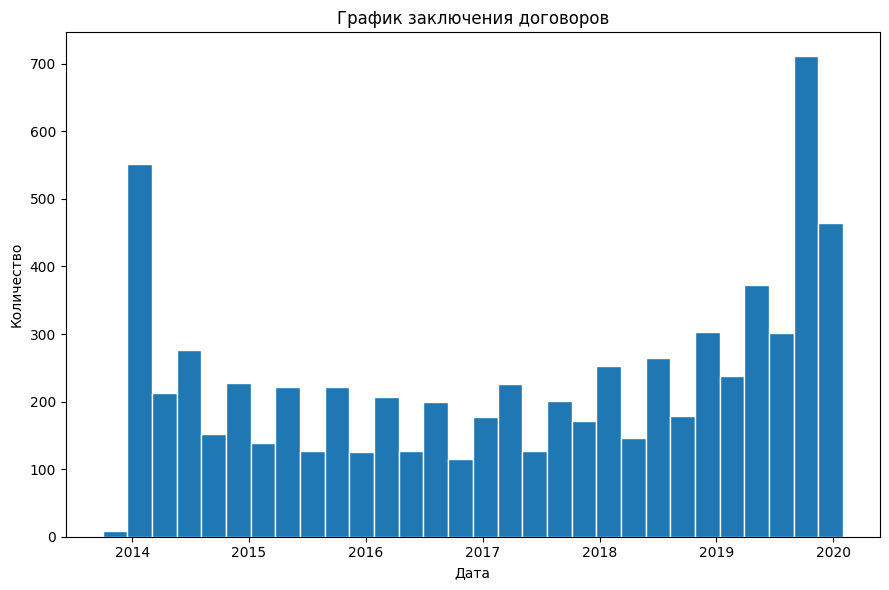

In [35]:
plt.hist(df_full['begin_date'], bins=30, edgecolor='white')
plt.title('График заключения договоров')
plt.xlabel('Дата')
plt.ylabel('Количество')
plt.tight_layout()
plt.show()



___
    Вывод по begin_date:
    Мы имеем данные с 2013-10-01 по 2020-02-01
    Договоры заключались почти равномерно с 2015 по 2018
    Много договоров было заключено в начале 2014-го (или начало 2014-го стало заглушкой для большинства договоров, которые были заключены ранее)
    Начиная с 2018, кол-во заключенных договоров растёт, с 2019-го это особо заметно
___




___
    Проанализируем признак end_date
    Сразу выделим в отдельный фрейм пользователей, которые разорвали договор
___


In [36]:
df_has_end_date = df_full.query('end_date != "No"')
df_has_end_date['end_date'] = pd.to_datetime(df_has_end_date['end_date'])

C:\Users\koziy\AppData\Local\Temp\ipykernel_17424\3707556758.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_has_end_date['end_date'] = pd.to_datetime(df_has_end_date['end_date'])


In [37]:
df_has_end_date['end_date'].count()

np.int64(1101)



___
    1101 договор был разорван за эти года
    Сделаем график, когда договора были разорваны
___


In [38]:
df_has_end_date['end_date'].describe()

count                             1101
mean     2018-03-12 18:21:15.204359680
min                2014-06-01 00:00:00
25%                2017-05-01 00:00:00
50%                2018-06-01 00:00:00
75%                2019-04-01 00:00:00
max                2020-01-01 00:00:00
Name: end_date, dtype: object

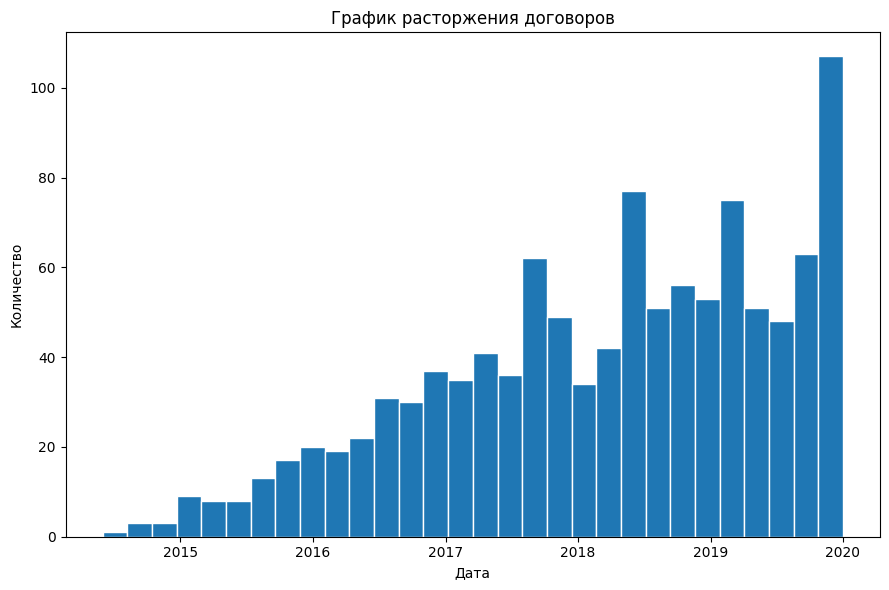

In [39]:
plt.hist(df_has_end_date['end_date'], bins=30, edgecolor='white')
plt.title('График расторжения договоров')
plt.xlabel('Дата')
plt.ylabel('Количество')
plt.tight_layout()
plt.show()



___
    Вывод по begin_date:
    Договора разрывались с 2014-06-01 по 2020-01-01
    По графику хорошо видно, что со временем кол-во договоров разрывается больше и больше
    
    Этот признак является целевым, но в таком виде его не получится использовать. 
    На основе этого признака, в следующих этапах мы создадим новый признак, разорвал ли клиент контракт - Yes/No
    А сам признак удалим, т.к. он является утечкой целевого признака
    Также можно заранее сказать, что у нас дисбаланс классов
___




___
    Проведём анализ признака type
___


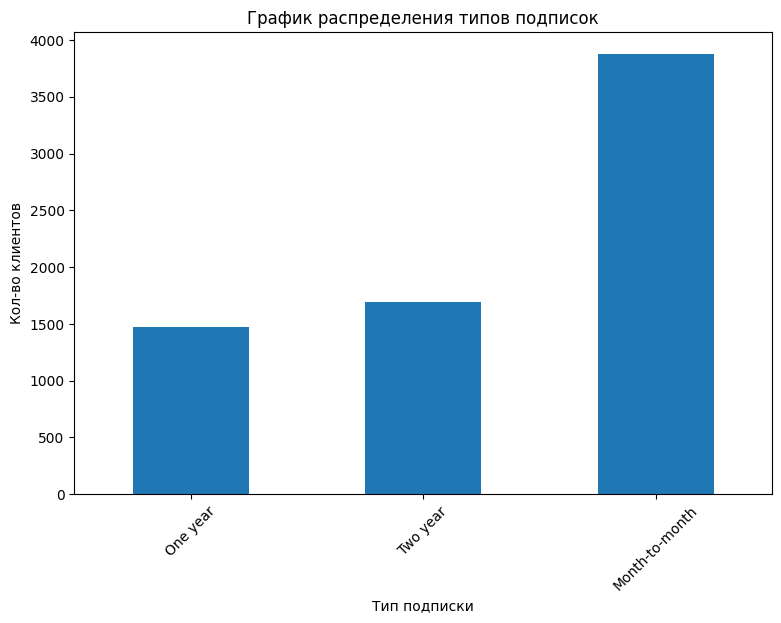

In [40]:
df_full.groupby('type').size().sort_values().plot(kind='bar')
plt.xlabel('Тип подписки')
plt.ylabel('Кол-во клиентов')
plt.title('График распределения типов подписок')
plt.xticks(rotation=45)

plt.show()

___
    Вывод по type:
    Самый популярный тип подписки: помесячный (month-to-month)
    Второй по популярности: раз в 2 года
    Третий, но не далеко от второго: раз в год 
___



___

    Проведем анализ признака paperless_billing
___


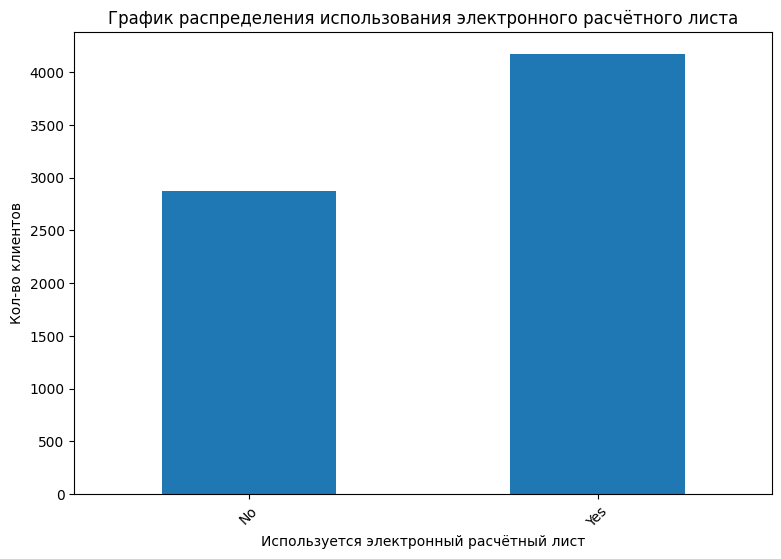

In [41]:
df_full.groupby('paperless_billing').size().sort_values().plot(kind='bar')
plt.xlabel('Используется электронный расчётный лист')
plt.ylabel('Кол-во клиентов')
plt.title('График распределения использования электронного расчётного листа')
plt.xticks(rotation=45)

plt.show()



___

    Вывод по paperless_billing:
    Большинство клиентов использует электронный расчёт лист, 
    но достаточно много клиентов его и не использует
    Пока ничего более конкретного об этом сказать нельзя
___




___

    Проведем анализ признака payment_method
___


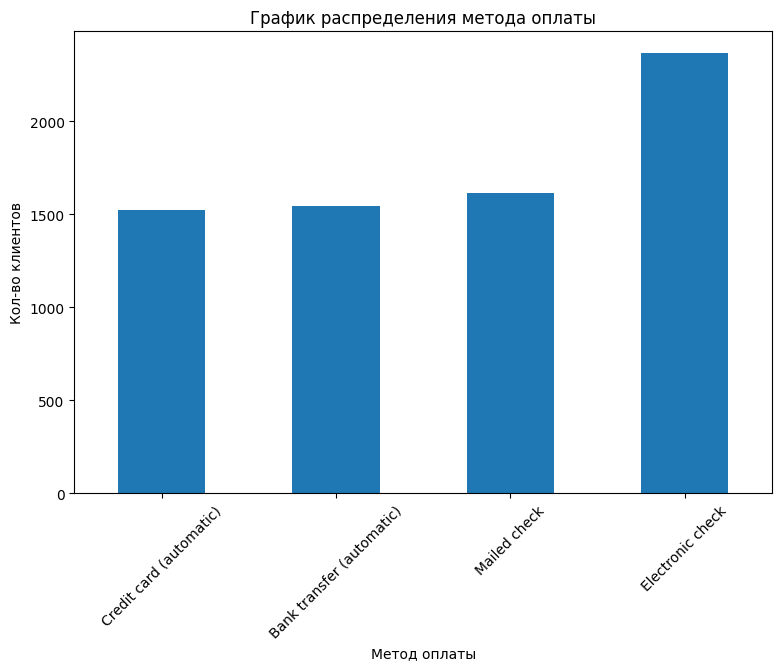

In [42]:
df_full.groupby('payment_method').size().sort_values().plot(kind='bar')
plt.xlabel('Метод оплаты')
plt.ylabel('Кол-во клиентов')
plt.title('График распределения метода оплаты')
plt.xticks(rotation=45)
plt.show()

___
    Вывод по payment_method:
    Самый часто используемый тип оплаты: Electronic check
    Все другие распределены равномерно
___



___

    Проведем анализ признака monthly_charges
___


In [43]:
df_full['monthly_charges'].describe()

count    7043.000000
mean       64.761692
std        30.090047
min        18.250000
25%        35.500000
50%        70.350000
75%        89.850000
max       118.750000
Name: monthly_charges, dtype: float64

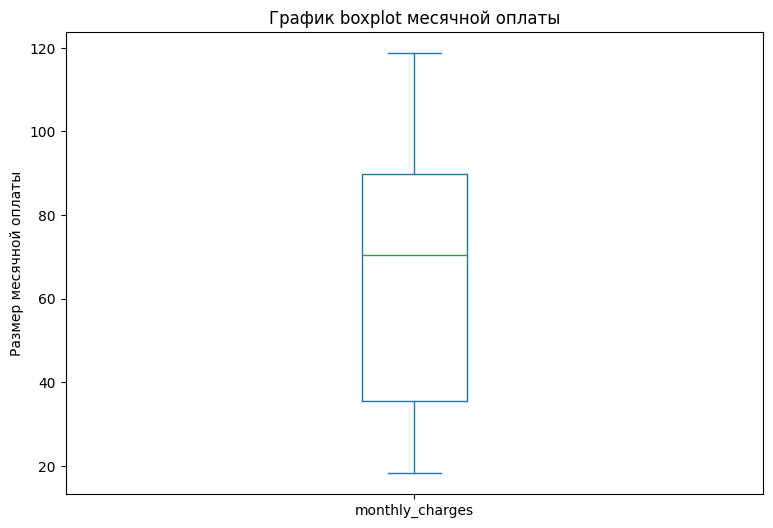

In [44]:
df_full.plot(kind='box', y='monthly_charges')
plt.ylabel('Размер месячной оплаты')
plt.title('График boxplot месячной оплаты')

plt.show()

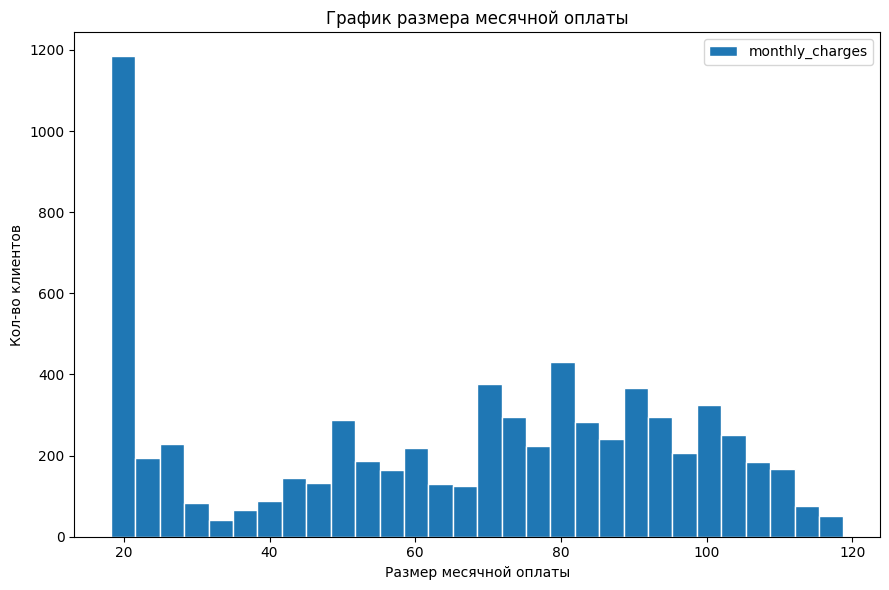

In [45]:
df_full.plot(kind='hist', y='monthly_charges', bins=30, edgecolor='white')
plt.xlabel('Размер месячной оплаты')
plt.ylabel('Кол-во клиентов')
plt.title('График размера месячной оплаты')
plt.tight_layout()

plt.show()

___
    Вывод по monthly_charges:
    Выбросов нет
    Средняя месячная оплата: 64.76
    Минимальная месячная оплата: 18.25
    Максимальная месячная оплата: 118.75
    
    По графику видно, что
    Самая часто встречаемая оплата: 20
    Близка к минимальной. Возможно, это какой-то минимальный пакет
___



___

    Проведем анализ признака total_charges
___


In [46]:
df_full['total_charges'].describe()

count    7043.000000
mean     2115.312885
std      2112.742814
min         0.000000
25%       436.750000
50%      1343.350000
75%      3236.690000
max      9221.380000
Name: total_charges, dtype: float64

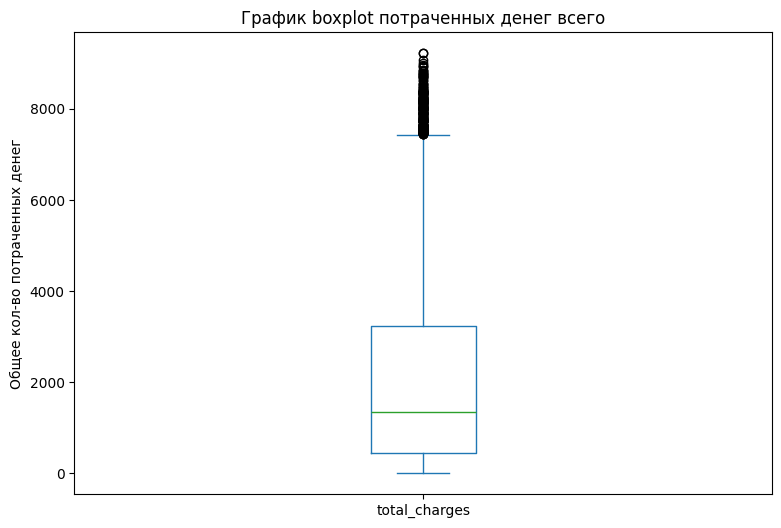

In [47]:
df_full.plot(kind='box', y='total_charges')
plt.ylabel('Общее кол-во потраченных денег')
plt.title('График boxplot потраченных денег всего')

plt.show()

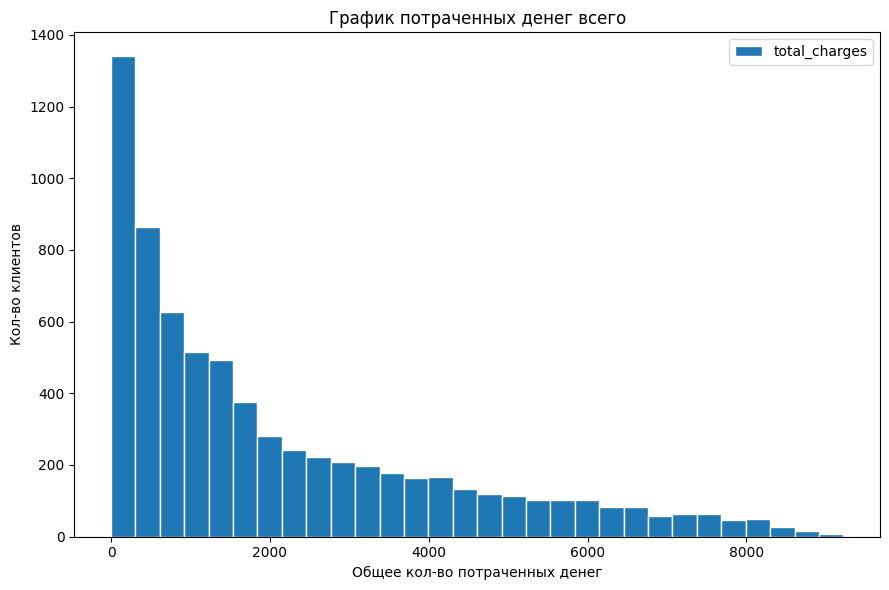

In [48]:
df_full.plot(kind='hist', y='total_charges', bins=30, edgecolor='white')
plt.xlabel('Общее кол-во потраченных денег')
plt.ylabel('Кол-во клиентов')
plt.title('График потраченных денег всего')
plt.tight_layout()

plt.show()

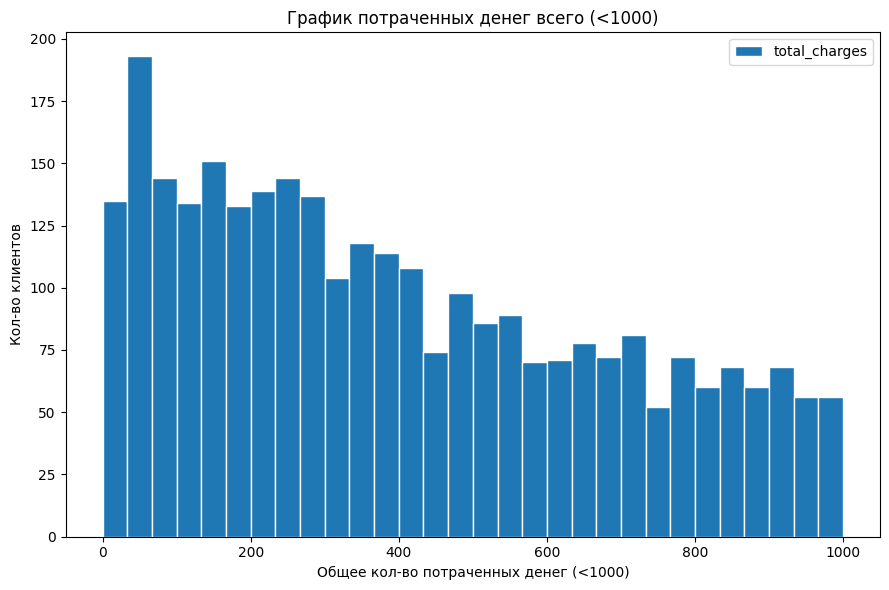

In [49]:
df_full.query('total_charges < 1000').plot(kind='hist', y='total_charges', bins=30, edgecolor='white')
plt.xlabel('Общее кол-во потраченных денег (<1000)')
plt.ylabel('Кол-во клиентов')
plt.title('График потраченных денег всего (<1000)')
plt.tight_layout()

plt.show()

In [50]:
df_full.query('total_charges == 0')['customer_id'].count()

np.int64(11)

___
    Вывод по total_charges:
    Выбросы есть, но они идут друг за другом от основного графика, 
    а далёких-уникальных выбросов нет, поэтому удалять ничего не будем
    
    Средняя суммарная оплата: 2115.31
    Минимальная суммарная оплата: 0 (контракт заключен в день сбора данных. Таких, всего 11 клиентов)
    Максимальная суммарная оплата: 9221.38
    
    По графику видно, что
    Самая часто встречаемая оплата близка к минимальной
    Это связано с тем, что большое кол-во клиентов подключилось недавно и пока не тратили много денег
___



___

    Проведем анализ признака internet_service
___


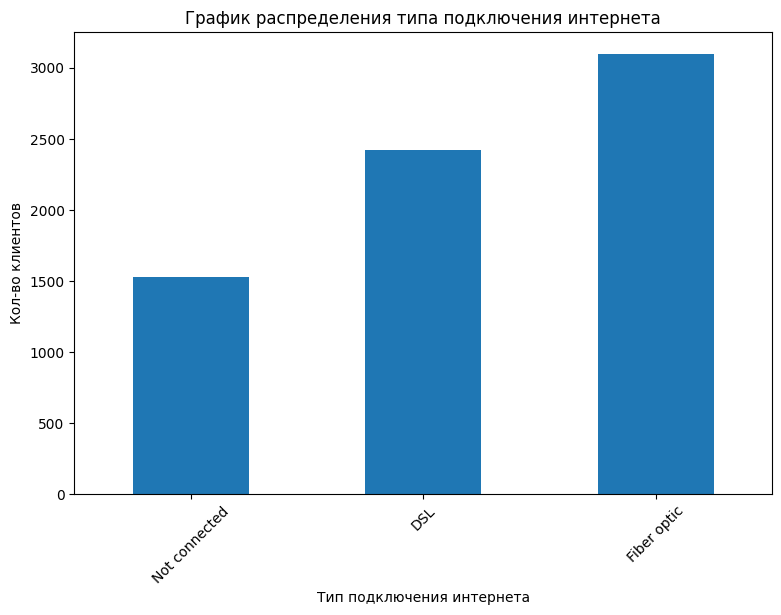

In [51]:
df_full.groupby('internet_service').size().sort_values().plot(kind='bar')
plt.xlabel('Тип подключения интернета')
plt.ylabel('Кол-во клиентов')
plt.title('График распределения типа подключения интернета')
plt.xticks(rotation=45)
plt.show()

___
    Вывод по internet_service:
    Самый часто используемый тип подключения: Fiber optic
    Далее идёт DSL
    И достаточно много клиентов не имеют никаких подключений - 1500
___



___

    Проведем анализ признака online_security
___


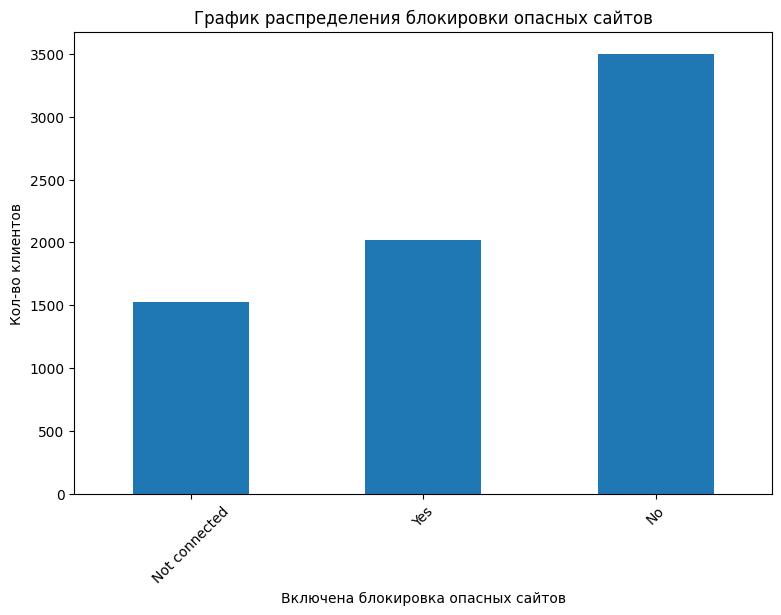

In [52]:
df_full.groupby('online_security').size().sort_values().plot(kind='bar')
plt.xlabel('Включена блокировка опасных сайтов')
plt.ylabel('Кол-во клиентов')
plt.title('График распределения блокировки опасных сайтов')
plt.xticks(rotation=45)
plt.show()

___
    Вывод по online_security:
    У большинства клиентов не подключена эта услуга или она просто выключена
    Только 2000 клиентов пользуется этой услугой
___



___

    Проведем анализ признака online_backup
___


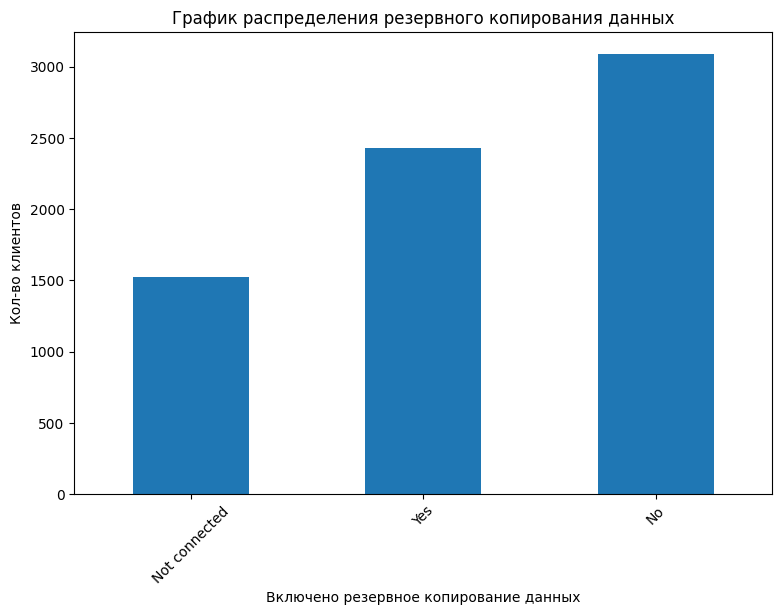

In [53]:
df_full.groupby('online_backup').size().sort_values().plot(kind='bar')
plt.xlabel('Включено резервное копирование данных')
plt.ylabel('Кол-во клиентов')
plt.title('График распределения резервного копирования данных')
plt.xticks(rotation=45)
plt.show()

___
    Вывод по online_backup:
    Всё похоже на online_security, но этой услугой пользуется больше клиентов
    2500 клиентов пользуется этой услугой
___



___

    Проведем анализ признака device_protection
___


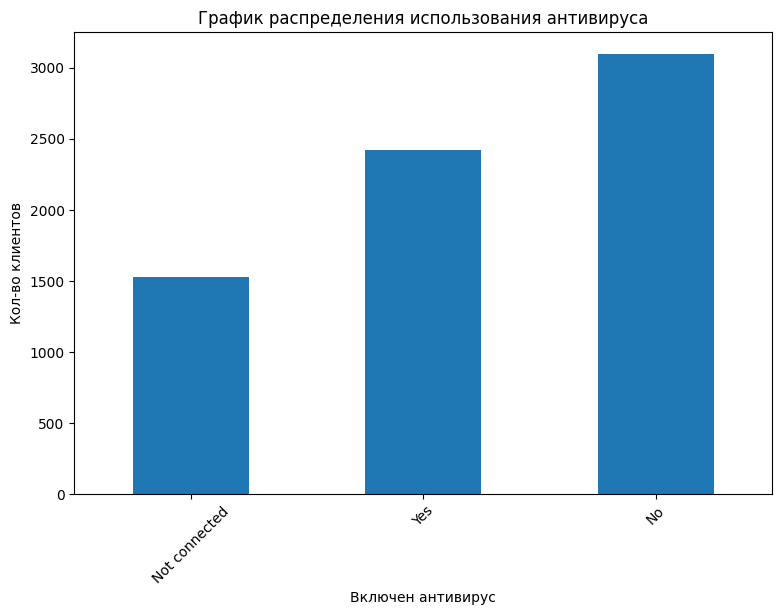

In [54]:
df_full.groupby('device_protection').size().sort_values().plot(kind='bar')
plt.xlabel('Включен антивирус')
plt.ylabel('Кол-во клиентов')
plt.title('График распределения использования антивируса')
plt.xticks(rotation=45)
plt.show()

___
    Вывод по device_protection:
    Всё также, как и у online_backup
    Большинство не пользуются этой услугой
    Только 2500 клиентов пользуется
___



___

    Проведем анализ признака tech_support
___


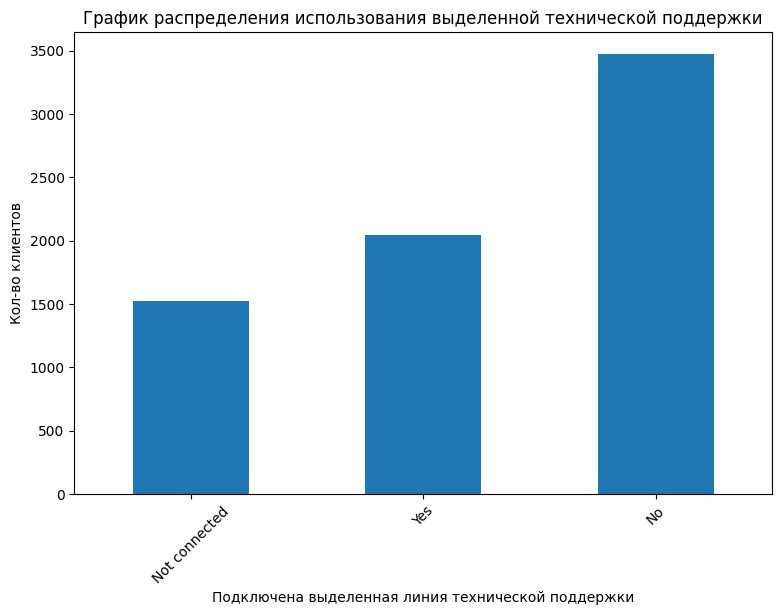

In [55]:
df_full.groupby('tech_support').size().sort_values().plot(kind='bar')
plt.xlabel('Подключена выделенная линия технической поддержки')
plt.ylabel('Кол-во клиентов')
plt.title('График распределения использования выделенной технической поддержки')
plt.xticks(rotation=45)
plt.show()

___
    Вывод по tech_support:
    Большинство не пользуются этой услугой
    У 1500 не подключена эта услуга
    Только 2100 клиентов пользуется
___



___

    Проведем анализ признака streaming_tv
___


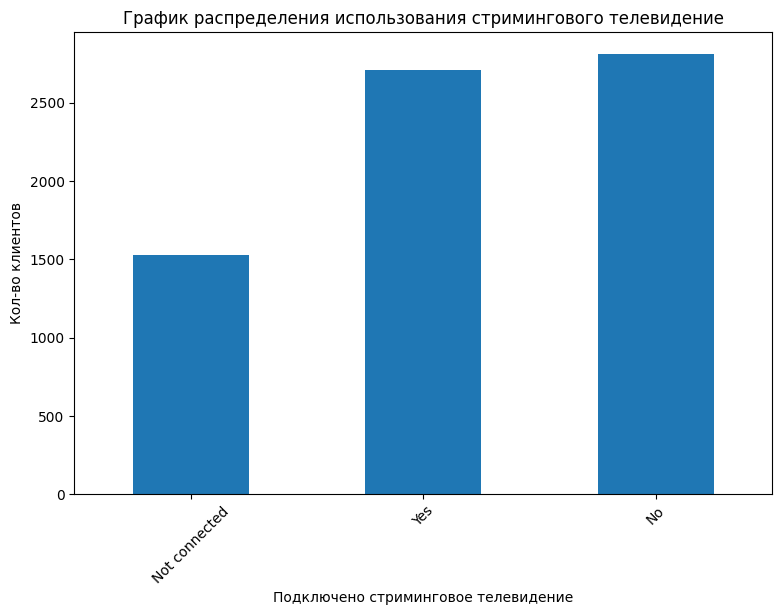

In [56]:
df_full.groupby('streaming_tv').size().sort_values().plot(kind='bar')
plt.xlabel('Подключено стриминговое телевидение')
plt.ylabel('Кол-во клиентов')
plt.title('График распределения использования стримингового телевидение')
plt.xticks(rotation=45)
plt.show()

___
    Вывод по streaming_tv:
    У 1500 нет этого пакета услуг
    У кого есть этот пакет услуг, разделились примерно поровну между теми, 
    у кого есть эта услуга в пакете и между теми, у кого ее нет. Примерно по 2700
___



___

    Проведем анализ признака streaming_movies
___


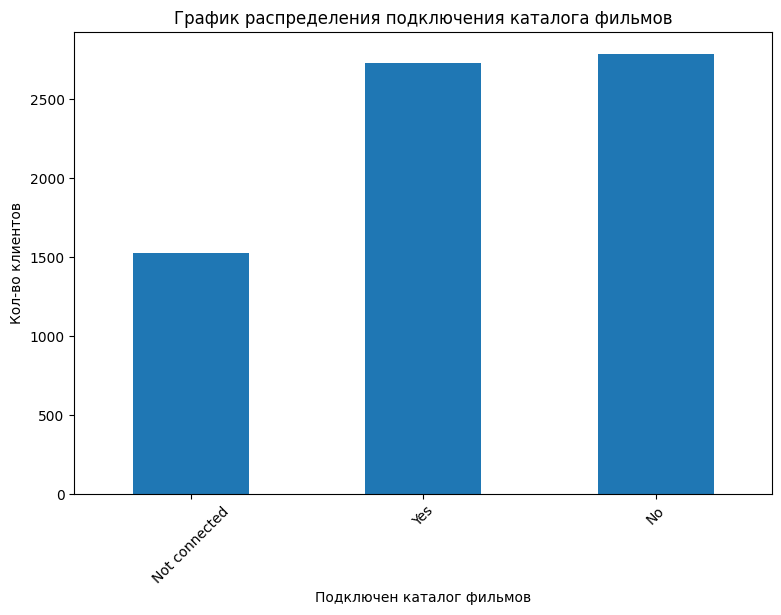

In [57]:
df_full.groupby('streaming_movies').size().sort_values().plot(kind='bar')
plt.xlabel('Подключен каталог фильмов')
plt.ylabel('Кол-во клиентов')
plt.title('График распределения подключения каталога фильмов')
plt.xticks(rotation=45)
plt.show()

___
    Вывод по streaming_movies:
    Ситуация такя же, как и у streaming_tv
    У 1500 нет этого пакета услуг
    У кого есть этот пакет услуг, разделились примерно поровну между теми, 
    у кого есть эта услуга в пакете и между теми, у кого ее нет. Примерно по 2700
___



___

    Проведем анализ признака gender
___


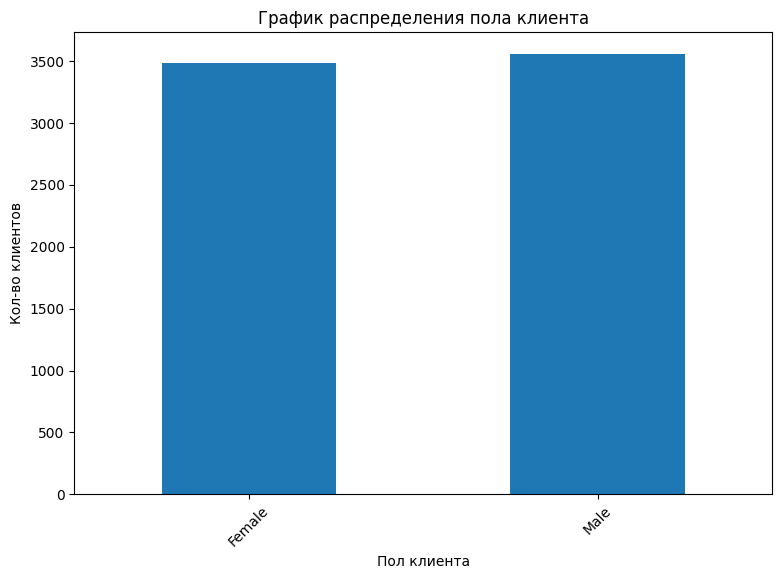

In [58]:
df_full.groupby('gender').size().sort_values().plot(kind='bar')
plt.xlabel('Пол клиента')
plt.ylabel('Кол-во клиентов')
plt.title('График распределения пола клиента')
plt.xticks(rotation=45)
plt.show()

___
    Вывод по gender:
    Клиенты поделены примерно поровну
    Мужская аудитория лишь на малость превышает женскую
___



___

    Проведем анализ признака senior_citizen
___


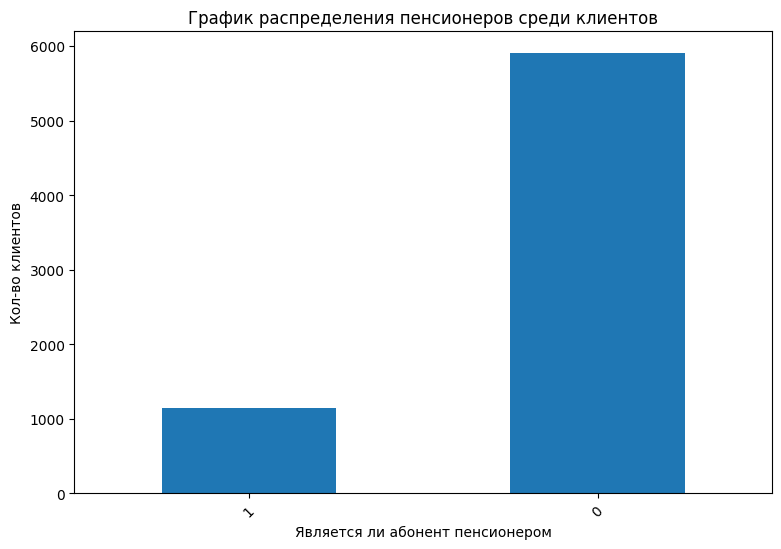

In [59]:
df_full.groupby('senior_citizen').size().sort_values().plot(kind='bar')
plt.xlabel('Является ли абонент пенсионером')
plt.ylabel('Кол-во клиентов')
plt.title('График распределения пенсионеров среди клиентов')
plt.xticks(rotation=45)
plt.show()

___
    Вывод по senior_citizen:
    Около 1100 клиентов являются пенсионерами 
    И почти 6000 ими не являются
    Услугами компании пользуются и пенсионеры
___

___

    Проведем анализ признака partner
___

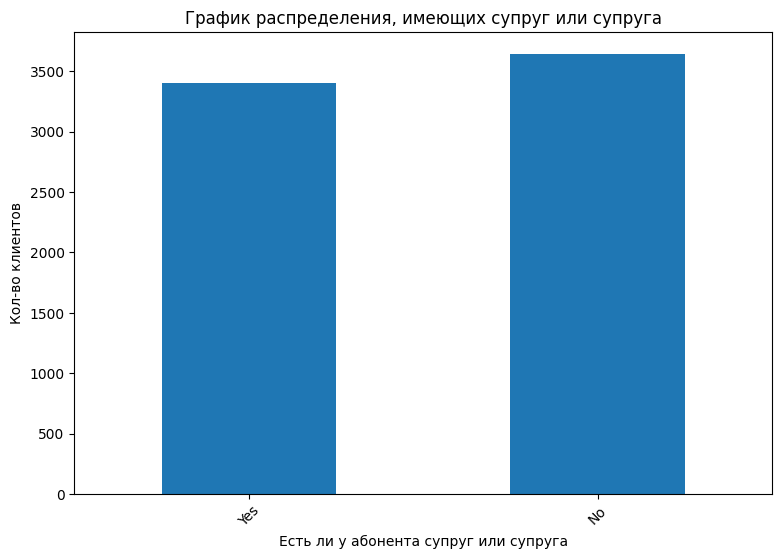

In [60]:
df_full.groupby('partner').size().sort_values().plot(kind='bar')
plt.xlabel('Есть ли у абонента супруг или супруга')
plt.ylabel('Кол-во клиентов')
plt.title('График распределения, имеющих супруг или супруга')
plt.xticks(rotation=45)
plt.show()

___
    Вывод по partner:
    График распределен почти равномерно
    Но у большинства нет супруга или супруги (3600 против 3400)
___

___

    Проведем анализ признака dependents
___

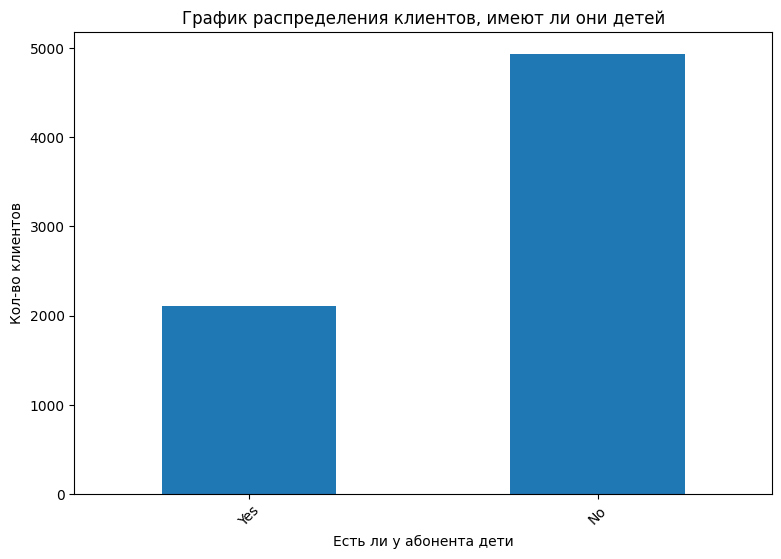

In [61]:
df_full.groupby('dependents').size().sort_values().plot(kind='bar')
plt.xlabel('Есть ли у абонента дети')
plt.ylabel('Кол-во клиентов')
plt.title('График распределения клиентов, имеют ли они детей')
plt.xticks(rotation=45)
plt.show()

___
    Вывод по dependents:
    У большинства клиентов нет детей - 4900
    Лишь у 2100 клиентов есть дети
___

___

    Проведем анализ признака multiple_lines
___

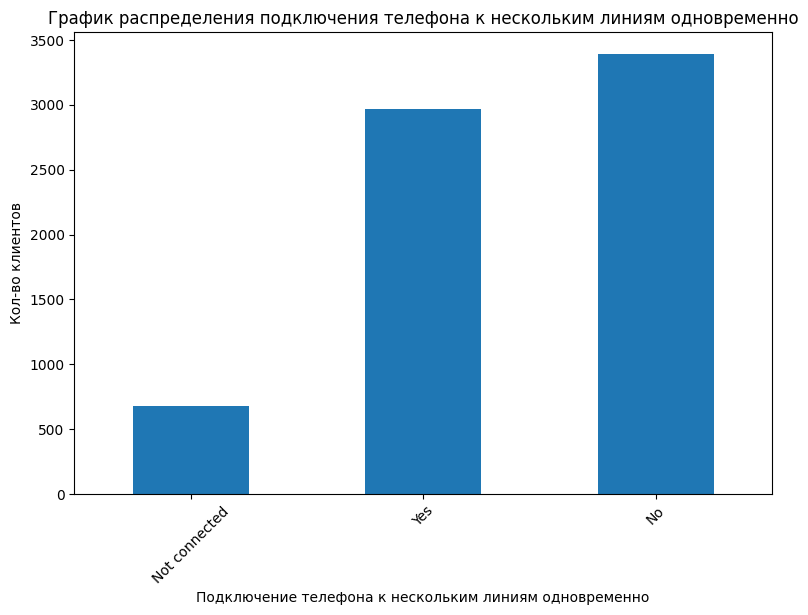

In [62]:
df_full.groupby('multiple_lines').size().sort_values().plot(kind='bar')
plt.xlabel('Подключение телефона к нескольким линиям одновременно')
plt.ylabel('Кол-во клиентов')
plt.title('График распределения подключения телефона к нескольким линиям одновременно')
plt.xticks(rotation=45)
plt.show()

___
    Вывод по multiple_lines:
    Большинство клиентов не пользуются этой услугой
    3400 не подключили это услугу в пакете
    У 700 клиентов нет этого пакета услуг
    2900 пользуются этой услугой
___

___
###    Вывод:

   **Все клиенты**

    - begin_date
    Мы имеем данные с 2013-10-01 по 2020-02-01.
    Договоры заключались почти равномерно с 2015 по 2018.
    Много договоров было заключено в начале 2014-го (или начало 2014-го стало заглушкой для большинства договоров, которые были заключены ранее).
    Начиная с 2018, кол-во заключенных договоров растёт, с 2019-го это особо заметно.

    - end_date
    1101 договор был разорван за эти года.
    Договора разрывались с 2014-06-01 по 2020-01-01.
    По графику хорошо видно, что со временем кол-во договоров разрывается больше и больше.

    - type
    Самый популярный тип подписки: помесячный (month-to-month).
    Второй по популярности: раз в 2 года.
    Третий, но не далеко от второго: раз в год.

    - paperless_billing
    Большинство клиентов использует электронный расчётный лист.
    Достаточно много клиентов его и не использует.

    - payment_method
    Самый часто используемый тип оплаты: Electronic check.
    Все другие распределены равномерно.

    - monthly_charges
    Выбросов нет.
    Средняя месячная оплата: 64.76.
    Минимальная месячная оплата: 18.25.
    Максимальная месячная оплата: 118.75.
    По графику видно, что самая часто встречаемая оплата: 20.
    Близка к минимальной. Возможно, это какой-то минимальный пакет.

    - total_charges
    Выбросы есть, но они идут друг за другом от основного графика, а далёких-уникальных выбросов нет.
    Средняя суммарная оплата: 2115.31.
    Минимальная суммарная оплата: 0 (контракт заключен в день сбора данных. Таких, всего 11 клиентов).
    Максимальная суммарная оплата: 9221.38.
    По графику видно, что самая часто встречаемая оплата близка к минимальной.
    Это связано с тем, что большое кол-во клиентов подключилось недавно и пока не тратили много денег.

    - internet_service
    Самый часто используемый тип подключения: Fiber optic.
    Далее идёт DSL.
    Достаточно много клиентов не имеют никаких подключений - 1500.

    - online_security
    У большинства клиентов не подключена эта услуга или она просто выключена.
    Только 2000 клиентов пользуется этой услугой.

    - online_backup
    Всё похоже на online_security, но этой услугой пользуется больше клиентов.
    2500 клиентов пользуется этой услугой.

    - device_protection
    Всё также, как и у online_backup.
    Большинство не пользуются этой услугой.
    Только 2500 клиентов пользуется.

    - tech_support
    Большинство не пользуются этой услугой.
    У 1500 не подключена эта услуга.
    Только 2100 клиентов пользуется.

    - streaming_tv
    У 1500 нет этого пакета услуг.
    У кого есть этот пакет услуг, разделились примерно поровну между теми, у кого есть эта услуга в пакете и между теми, у кого ее нет. Примерно по 2700.

    - streaming_movies
    Ситуация такая же, как и у streaming_tv.
    У 1500 нет этого пакета услуг.
    У кого есть этот пакет услуг, разделились примерно поровну между теми, у кого есть эта услуга в пакете и между теми, у кого ее нет. Примерно по 2700.

    - gender
    Клиенты поделены примерно поровну.
    Мужская аудитория лишь на малость превышает женскую.

    - senior_citizen
    Около 1100 клиентов являются пенсионерами.
    И почти 6000 ими не являются.
    Услугами компании пользуются и пенсионеры.

    - partner
    График распределен почти равномерно.
    Но у большинства нет супруга или супруги (3600 против 3400).

    - dependents
    У большинства клиентов нет детей - 4900.
    Лишь у 2100 клиентов есть дети.

    - multiple_lines
    Большинство клиентов не пользуются этой услугой.
    3400 не подключили эту услугу в пакете.
    У 700 клиентов нет этого пакета услуг.
    2900 пользуются этой услугой.

**Портрет типичного клиента:**

    Это относительно новый клиент с помесячной оплатой, 
    предпочитающий цифровые каналы взаимодействия (электронный чек, электронный счет). 
    Он пользуется базовым интернет-тарифом без большого количества дополнительных платных опций. 
    Это не пенсионер, скорее всего, без детей и, возможно, без партнера. 
    Такой клиент ориентирован на получение основной услуги по приемлемой цене, без излишеств.
___

## Создание новых признаков

---
    Добавим новые признаки для улучшения работы модели

    Предлагается создать:
    1. Сам целевой признак - расторг ли клиент договор (terminated: Yes/No)
    2. Длительность активности контракта - сколько дней контракт активен (days_use: N)
    3. Оценку стабильности клиента в зависимости от его других параметров - (stability_score: N)
---

In [63]:
df_full['terminated'] = df_full['end_date'] != 'No'

In [64]:
df_full[['customer_id', 'end_date', 'terminated']].head(15)

,customer_id,end_date,terminated
0,0002-ORFBO,No,False
1,0003-MKNFE,No,False
2,0004-TLHLJ,No,False
3,0011-IGKFF,No,False
4,0013-EXCHZ,No,False
5,0013-MHZWF,No,False
6,0013-SMEOE,No,False
7,0014-BMAQU,No,False
8,0015-UOCOJ,No,False
9,0016-QLJIS,No,False


In [65]:
end = pd.to_datetime(df_full['end_date'].replace('No', '2020-02-01'))
beg = df_full['begin_date']

df_full['days_use'] = (end - beg).dt.days            

In [66]:
df_full[['customer_id', 'begin_date', 'end_date', 'days_use']].head(10)

,customer_id,begin_date,end_date,days_use
0,0002-ORFBO,2019-05-01,No,276
1,0003-MKNFE,2019-05-01,No,276
2,0004-TLHLJ,2019-09-01,No,153
3,0011-IGKFF,2018-12-01,No,427
4,0013-EXCHZ,2019-09-01,No,153
5,0013-MHZWF,2019-05-01,No,276
6,0013-SMEOE,2014-03-01,No,2163
7,0014-BMAQU,2014-11-01,No,1918
8,0015-UOCOJ,2019-07-01,No,215
9,0016-QLJIS,2014-09-01,No,1979


---
    Сразу удалим признак, который нам уже не нужен - end_date и begin_date
    Мы на основе него создали целевой признак - terminated
    А теперь end_date является утечкой целевого признака 
    
    Также удалим customer_id и begin_date. Эти признаки нам тоже уже не нужны
    
---

In [67]:
df_full = df_full.drop(['end_date', 'begin_date', 'customer_id'], axis=1)

In [68]:
df_full.head()

,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,gender,senior_citizen,partner,dependents,multiple_lines,terminated,days_use
0,One year,Yes,Mailed check,65.6,631.73,DSL,No,Yes,No,Yes,Yes,No,Female,0,Yes,Yes,No,False,276
1,Month-to-month,No,Mailed check,59.9,539.10,DSL,No,No,No,No,No,Yes,Male,0,No,No,Yes,False,276
2,Month-to-month,Yes,Electronic check,73.9,406.45,Fiber optic,No,No,Yes,No,No,No,Male,0,No,No,No,False,153
3,Month-to-month,Yes,Electronic check,98.0,1372.00,Fiber optic,No,Yes,Yes,No,Yes,Yes,Male,1,Yes,No,No,False,427
4,Month-to-month,Yes,Mailed check,83.9,444.67,Fiber optic,No,No,No,Yes,Yes,No,Female,1,Yes,No,No,False,153


---
    Ещё раз посмотрим на распределение целевого признака
---

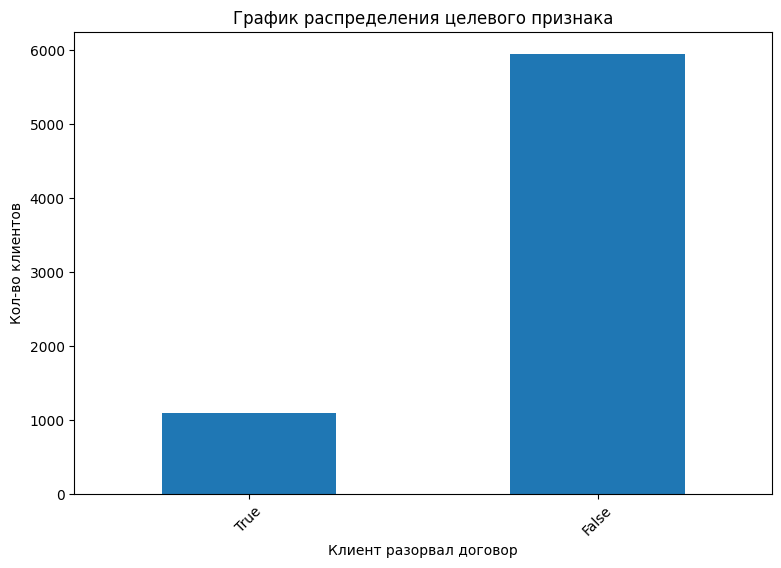

In [69]:
df_full.groupby('terminated').size().sort_values().plot(kind='bar')
plt.xlabel('Клиент разорвал договор')
plt.ylabel('Кол-во клиентов')
plt.title('График распределения целевого признака')
plt.xticks(rotation=45)
plt.show()

---
    Здесь явный дисбаланс целевого признака
    1000 клиентов, разорвавших договор на 6000 не разорвавших
    Это необходимо учитывать в будущем
---

## Корреляционный анализ

---
    Проведем корреляционный анализ признаков
---

---
    Изучим взаимосвязь между признаками:
    Рассчитаем коэффициенты корреляции между всеми признакам
---

In [70]:
df_full.head()

,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,gender,senior_citizen,partner,dependents,multiple_lines,terminated,days_use
0,One year,Yes,Mailed check,65.6,631.73,DSL,No,Yes,No,Yes,Yes,No,Female,0,Yes,Yes,No,False,276
1,Month-to-month,No,Mailed check,59.9,539.10,DSL,No,No,No,No,No,Yes,Male,0,No,No,Yes,False,276
2,Month-to-month,Yes,Electronic check,73.9,406.45,Fiber optic,No,No,Yes,No,No,No,Male,0,No,No,No,False,153
3,Month-to-month,Yes,Electronic check,98.0,1372.00,Fiber optic,No,Yes,Yes,No,Yes,Yes,Male,1,Yes,No,No,False,427
4,Month-to-month,Yes,Mailed check,83.9,444.67,Fiber optic,No,No,No,Yes,Yes,No,Female,1,Yes,No,No,False,153


In [71]:
interval_cols = ['monthly_charges', 'total_charges', 'days_use']

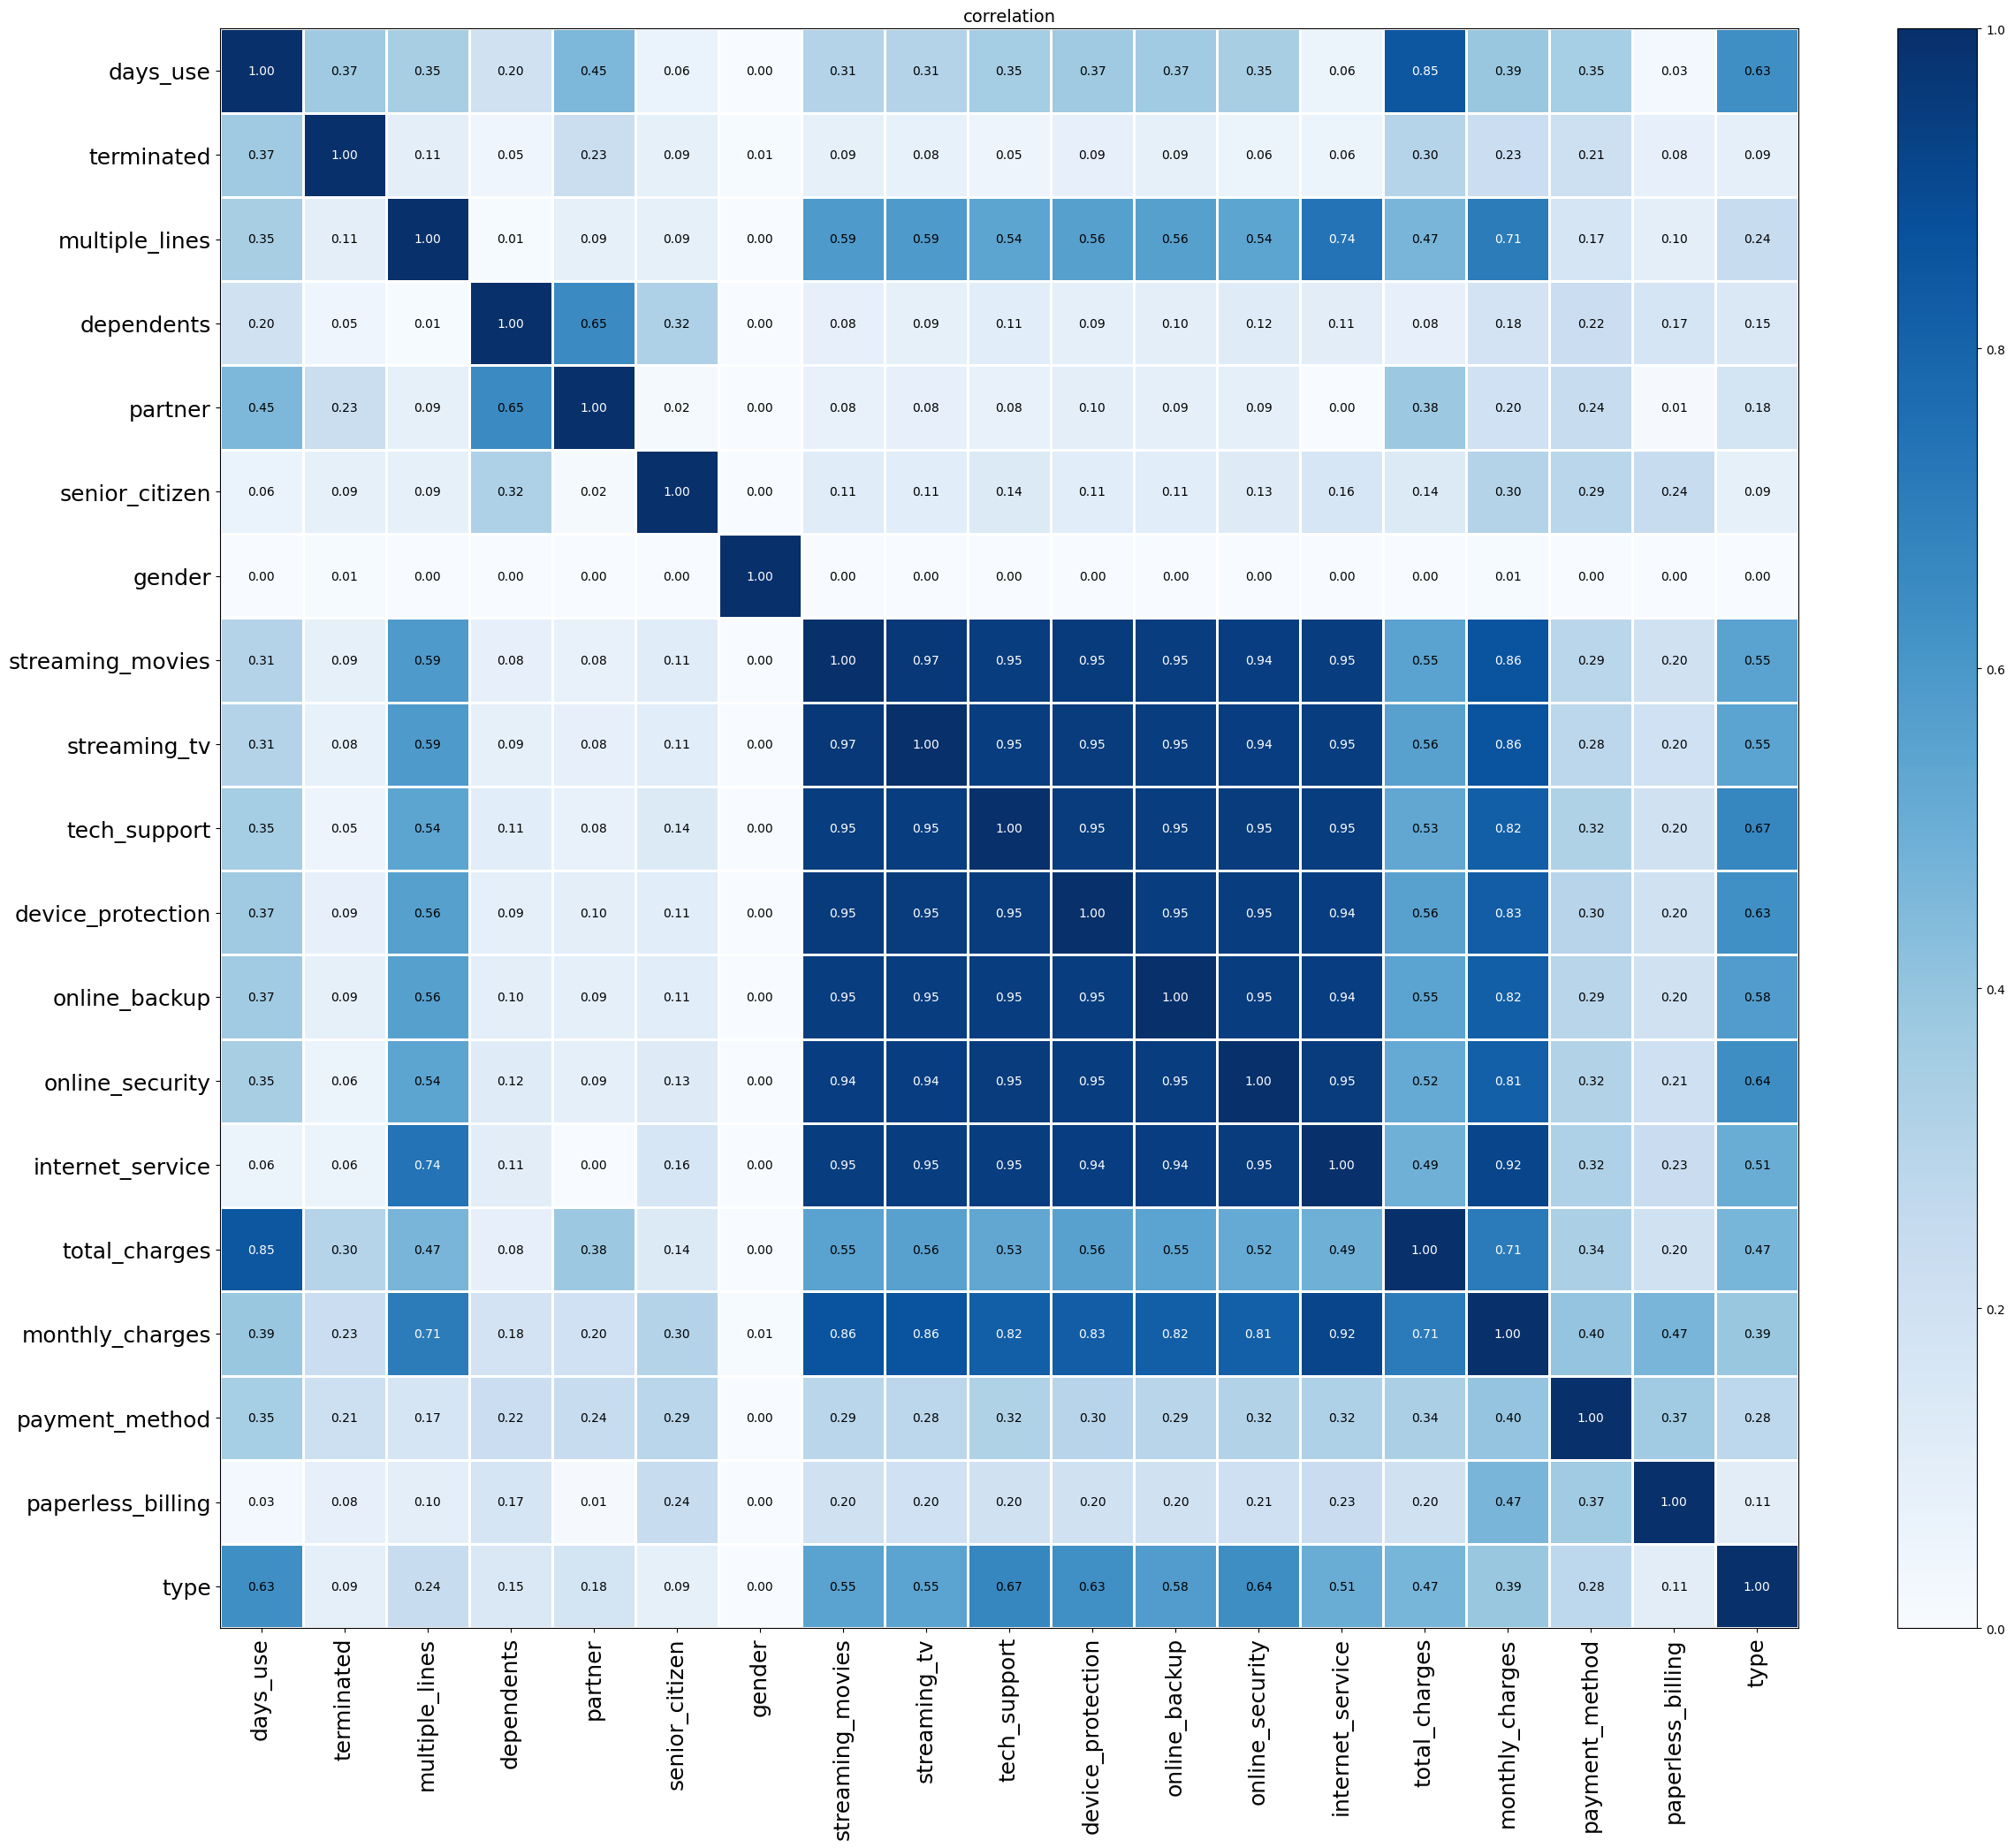

In [72]:
phik_matrix = df_full.phik_matrix(interval_cols=interval_cols)
plot_correlation_matrix(phik_matrix.values,
                        x_labels=phik_matrix.columns,
                        y_labels=phik_matrix.index,
                        vmin=0, vmax=1,
                        color_map='Blues',
                        figsize=(24, 20))

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()

In [73]:
df_full['internet_service'].unique()

array(['DSL', 'Fiber optic', 'Not connected'], dtype=object)

---
    У целевого признака нет сильной корреляции с другими признаками
    Самая сильная корреляция у целевого признака с кол-вом месяцев, сколько договор активен. 
    Корреляция с этим признаком составляет лишь 0.37, поэтому можно сказать, что ее практически нет

    Видим, что признак "пол" не влияет вообще ни на что. И этот признак бесполезен для нас
    Мы удалим его

    Также, видна мультиколлинеарность в области пакетов услуг
    Из выводов исследовательского анализа данных мы видим, 
    что графики признаков: tech_support, device_protection, online_backup, online_security практически идентичны
    А также идентичны графики: streaming_movies и streaming_tv
    Предлагается объединить эти 2 группы в 2 признака, удалив все остальные, чтобы избавиться от большого кол-ва мультиколлинеарности в данных
    Объединение можно сделать через числовой категориальный признак - кол-во подключенных услуг
    Для стриминга это будет: 0-2
    А для другой группы: 0-4

    Также, видим корреляцию между internet_service и monthly_charges
    И корреляцию между days_use и total_charges - чем дольше клиент работает с компанией, тем больше денег он потратил
    Мы можем избавиться от признака total_charges, чтобы устранить мультиколлинеарность
---

---
    Сгруппируем данные internet_service и посмотрим, 
    как распределена месячная оплата у разных клиентов с разным подключением интернета
---

In [74]:
df_full.groupby('internet_service')['monthly_charges'].agg(['mean','std','count']).sort_values(by='mean')


,mean,std,count
internet_service,,,
Not connected,21.079194,2.164221,1526
DSL,58.102169,16.259522,2421
Fiber optic,91.500129,12.663039,3096


---
    Те, у кого интернет не подключен совсем, тот платит меньше всего
    DSL используется для подключения интернета 10–50 Мбит/с
    А Fiber Optic для 100–1000 Мбит/с
    Поэтому, у кого Fiber Optic - у того больше скорость интернета - тот клиент платит в месяц больше

    Можем удалить признак internet_service для устранения мультиколлинеарности. Месячная оплата является более важным признаком
---

In [75]:
columns_to_sum_services = ['tech_support', 'device_protection', 'online_backup', 'online_security']
columns_to_sum_streaming = ['streaming_movies', 'streaming_tv']

In [76]:
df_full['count_services'] = (df_full[columns_to_sum_services] == 'Yes').sum(axis=1)
df_full['count_streaming'] = (df_full[columns_to_sum_streaming] == 'Yes').sum(axis=1)

---
    Теперь удалим признаки, которые нам больше не нужны
---

In [77]:
df_full = df_full.drop([
    'gender', 'streaming_movies', 'streaming_tv', 'tech_support', 'device_protection', 'online_backup', 'online_security', 'internet_service', 'total_charges'
], axis=1)

In [78]:
df_full.head()

,type,paperless_billing,payment_method,monthly_charges,senior_citizen,partner,dependents,multiple_lines,terminated,days_use,count_services,count_streaming
0,One year,Yes,Mailed check,65.6,0,Yes,Yes,No,False,276,2,1
1,Month-to-month,No,Mailed check,59.9,0,No,No,Yes,False,276,0,1
2,Month-to-month,Yes,Electronic check,73.9,0,No,No,No,False,153,1,0
3,Month-to-month,Yes,Electronic check,98.0,1,Yes,No,No,False,427,2,2
4,Month-to-month,Yes,Mailed check,83.9,1,Yes,No,No,False,153,1,1


---
    Посмотрим на корреляцию признаков ещё раз
---

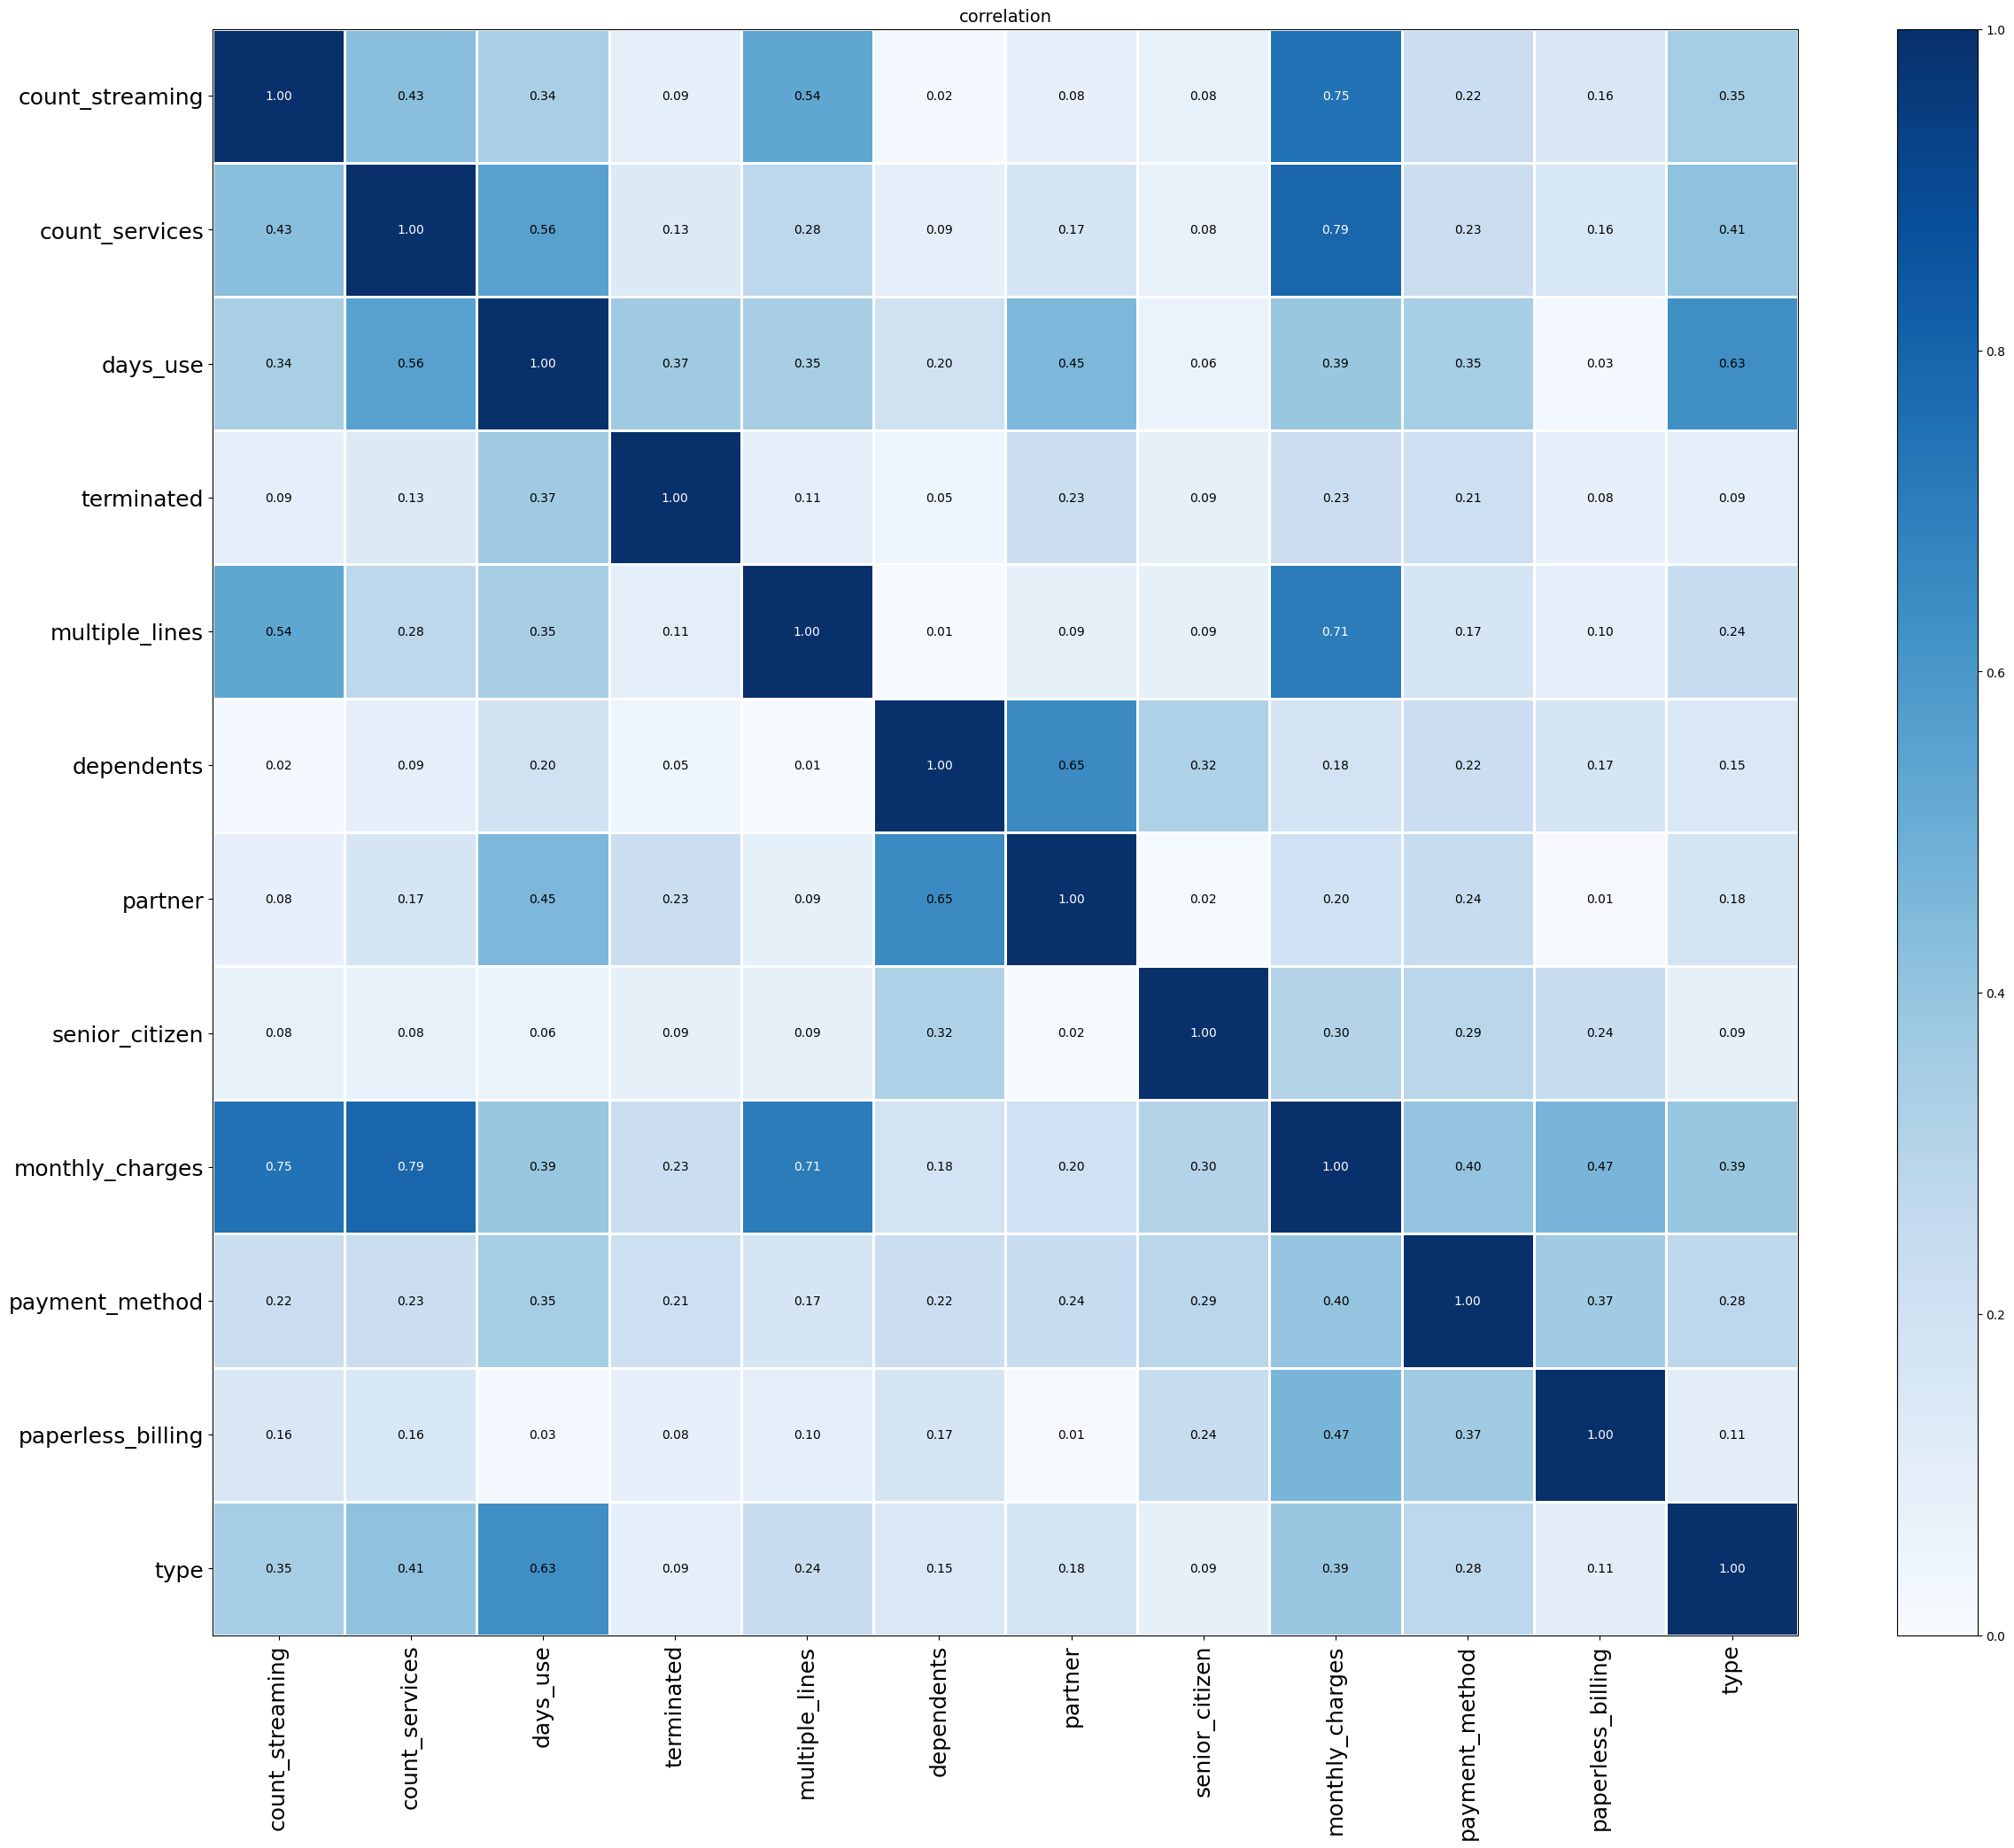

In [79]:
phik_matrix = df_full.phik_matrix(interval_cols=interval_cols)
plot_correlation_matrix(phik_matrix.values,
                        x_labels=phik_matrix.columns,
                        y_labels=phik_matrix.index,
                        vmin=0, vmax=1,
                        color_map='Blues',
                        figsize=(24, 20))

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()

---
**Итог**

    Мы определили, что
    У целевого признака нет сильной корреляции с другими признаками
    Признак "gender" не коррелирует ни с чем
    В области пакетов услуг присутствовала мультиколлинеарность

    Мы сделали:
    Объединили 2 группы (пакетов услуг и стриминга) в 2 признака
    Удалили признаки, на основе которых создавались 2 новые группы 
    (streaming_movies, streaming_tv, tech_support, device_protection, online_backup, online_security)
    Удалили отдельные признаки, вызывающие мультиколлинеарность
    Из-за ненадобности удалили признак gender
    Избавились от мультиколлинеарности
---

## Подготовка данных перед обучением

---
    Разделим выборку
---

In [80]:
X_train, X_test, y_train, y_test = train_test_split(
    df_full.drop(['terminated'], axis=1),
    df_full['terminated'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = df_full['terminated'])

X_train.shape, X_test.shape

((5282, 11), (1761, 11))

---
    Создадим списки с названиями признаков
---

In [81]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   type               7043 non-null   object 
 1   paperless_billing  7043 non-null   object 
 2   payment_method     7043 non-null   object 
 3   monthly_charges    7043 non-null   float64
 4   senior_citizen     7043 non-null   int64  
 5   partner            7043 non-null   object 
 6   dependents         7043 non-null   object 
 7   multiple_lines     7043 non-null   object 
 8   terminated         7043 non-null   bool   
 9   days_use           7043 non-null   int64  
 10  count_services     7043 non-null   int64  
 11  count_streaming    7043 non-null   int64  
dtypes: bool(1), float64(1), int64(4), object(6)
memory usage: 612.3+ KB


In [82]:
df_full.head()

,type,paperless_billing,payment_method,monthly_charges,senior_citizen,partner,dependents,multiple_lines,terminated,days_use,count_services,count_streaming
0,One year,Yes,Mailed check,65.6,0,Yes,Yes,No,False,276,2,1
1,Month-to-month,No,Mailed check,59.9,0,No,No,Yes,False,276,0,1
2,Month-to-month,Yes,Electronic check,73.9,0,No,No,No,False,153,1,0
3,Month-to-month,Yes,Electronic check,98.0,1,Yes,No,No,False,427,2,2
4,Month-to-month,Yes,Mailed check,83.9,1,Yes,No,No,False,153,1,1


In [83]:
ohe_columns = [
    'type', 
    'paperless_billing', 
    'payment_method', 
    'partner', 
    'dependents', 
    'multiple_lines'
]

num_columns = [
    'monthly_charges', 
    'days_use',
    'count_services', 
    'count_streaming'
]

---
    Создадим pipeline для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование
    SimpleImputer + OHE
---

In [84]:
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
    )

---
    Создадим общий pipeline для подготовки данных
---

In [85]:
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

---
    Создадим итоговый пайплайн: подготовка данных и модель
---

In [86]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

---
    К этому моменту наши данные закодированы и подготовлены для обучения на них моделей
---

## Обучение моделей

---
    Подготовим список моделей, которые будем обучать
    По условию, необходимо использовать только интерпретируемые модели.
---

In [87]:
param_grid = [
    # LogisticRegression
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE,
            solver='liblinear'                     
        )],
        'models__penalty'   : ['l1', 'l2'],
        'models__C'         : [0.1, 1, 10],
        'preprocessor__num' : [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    },
    # SVC
    {
        'models': [SVC(
            kernel='linear', 
            probability=True, 
            random_state=RANDOM_STATE
        )],
        'models__C': [0.1, 1, 10],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler()]
    },
    # RidgeClassifier
    {
        'models': [RidgeClassifier(random_state=RANDOM_STATE)],
        'models__alpha'     : [0.1, 1.0, 10.0],
        'models__solver'    : ['auto', 'sag', 'lsqr'],
        'preprocessor__num' : [StandardScaler(), MinMaxScaler(), RobustScaler()]
    },
    # CatBoost
    {
        'models': [CatBoostClassifier(
            random_state=RANDOM_STATE,
            verbose=0
        )],
        'models__n_estimators': [500, 800, 1200, 1600],
        'models__learning_rate': [0.01, 0.03, 0.05, 0.1],
        'models__depth': [4, 5, 6, 7],
        'models__l2_leaf_reg': [1, 3, 5, 7, 9],
        'models__random_strength': [1, 5, 10],
        'models__subsample': [0.7, 0.8, 0.9],
        'models__border_count': [32, 64, 128],
        'preprocessor__num' : [MinMaxScaler(), StandardScaler(), RobustScaler()]
    },
    # RandomForestClassifier
    {
        'models': [RandomForestClassifier(
            random_state=RANDOM_STATE,
            n_jobs=-1
        )],
        'models__n_estimators': [200, 400, 600],
        'models__max_depth'   : [None, 6, 10],
        'models__max_features': ['sqrt', 'log2'],
        'preprocessor__num'   : ['passthrough']
    },     
    # LightGBM
    {
        'models': [LGBMClassifier(
            random_state=RANDOM_STATE,
            n_jobs=-1,
            verbose=-1
        )],
        'models__n_estimators': [300, 600, 900],
        'models__learning_rate': [0.01, 0.05, 0.1],
        'models__max_depth'    : [-1, 5, 7],
        'models__num_leaves'   : [31, 63, 127],
        'models__subsample'    : [0.7, 0.8, 0.9],
        'preprocessor__num'    : [StandardScaler(), MinMaxScaler(), RobustScaler()]
    },
    # K-NN
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': [5, 10, 15],
        'models__weights'    : ['uniform', 'distance'],
        'models__metric'     : ['euclidean', 'manhattan'],
        'preprocessor__num'  : [StandardScaler(), MinMaxScaler(), RobustScaler()]
    }
]

In [88]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    n_iter=20,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)

C:\Users\koziy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\compose\_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['type',
                                                                                'paperless_billing',
                                                                                'payment_method',
                                                                                'partner',
                                                                                'depen...
                                         'models__subsample': [0.7, 0.8, 0.9],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               RobustScaler()]},
                                        {'models': [KNeighborsClassifier()],
                                         'models__metric': ['euclidean',
                                                            'manhattan'],
                                         'models__n_neighbors': [5, 10, 15],
                                         'models__weights': ['uniform',
                                                             'distance'],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               RobustScaler()]}],
                   random_state=20625, scoring='roc_auc')

___
    Используем метрику ROC-AUC, тк мы предсказываем бинарные значения, а классы не сбалансированы
___

In [89]:
print('Лучшая модель и ее параметры:\n\n', randomized_search.best_params_)
print ('Метрика лучшей модели на кросс-валидации:', randomized_search.best_score_)

Лучшая модель и ее параметры:

 {'preprocessor__num': StandardScaler(), 'models__subsample': 0.8, 'models__random_strength': 5, 'models__n_estimators': 1600, 'models__learning_rate': 0.05, 'models__l2_leaf_reg': 5, 'models__depth': 4, 'models__border_count': 128, 'models': <catboost.core.CatBoostClassifier object at 0x00000153100A7A50>}
Метрика лучшей модели на кросс-валидации: 0.9109448465694102


---
    Проверим работу модели на тестовой выборке
    Рассчитаем прогноз на тестовых данных
---

In [90]:
y_test_pred = randomized_search.predict_proba(X_test)[:, 1]
y_test_predicted_classes = randomized_search.predict(X_test)
accuracy = accuracy_score(y_test, y_test_predicted_classes)

print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_pred)}')
print(f"Метрика Accuracy на тестовой выборке: {accuracy:.4f}")

Метрика ROC-AUC на тестовой выборке: 0.9256809005261227
Метрика Accuracy на тестовой выборке: 0.9211


___
    Сделаем проверку модели на "адекватность"
    Используем для этого модель DummyClassifier
___

In [91]:
dummy = DummyClassifier(strategy='uniform', random_state=RANDOM_STATE)
dummy.fit(X_train, y_train)

probas = dummy.predict_proba(X_test)[:, 1]

auc = roc_auc_score(y_test, probas)
print(f"Метрика ROC-AUC, используя DummyClassifier: {auc}") 

Метрика ROC-AUC, используя DummyClassifier: 0.5


___
    Итог
    Лучшая модель с параметрами:  
    CatBoostClassifier
    {
        'preprocessor__num': StandardScaler(), 'models__subsample': 0.8, 
        'models__random_strength': 5, 'models__n_estimators': 1600, 
        'models__learning_rate': 0.05, 'models__l2_leaf_reg': 5, 
        'models__depth': 4, 'models__border_count': 128
    }
    Метрика ROC-AUC на тестовой выборке: 0.926

    Метрика Accuracy на тестовой выборке: 0.921   
    Это означает, что точность предсказания равна 92.1%
    Наша задача выявить потенциальных оттокающих клиентов (малый класс 15 %) и удержать их, высокая общая точность почти ничего не гарантирует.
    Для оценки качества работы надо смотреть на метрики для каждой группы отдельно
    ___

## Анализ важности признаков

___
    Оценим важность признаков для лучшей модели 
    и построим график важности с помощью метода SHAP. 
___

In [92]:
best_pipeline = randomized_search.best_estimator_
best_model = best_pipeline.named_steps['models']

X_train_transformed = best_pipeline.named_steps['preprocessor'].transform(X_train)
feature_names = best_pipeline.named_steps['preprocessor'].get_feature_names_out()

In [93]:
explainer = shap.TreeExplainer(best_model, X_train_transformed, feature_names=feature_names)

shap_values = explainer(X_train_transformed)

 99%|===================| 5223/5282 [01:17<00:00]        

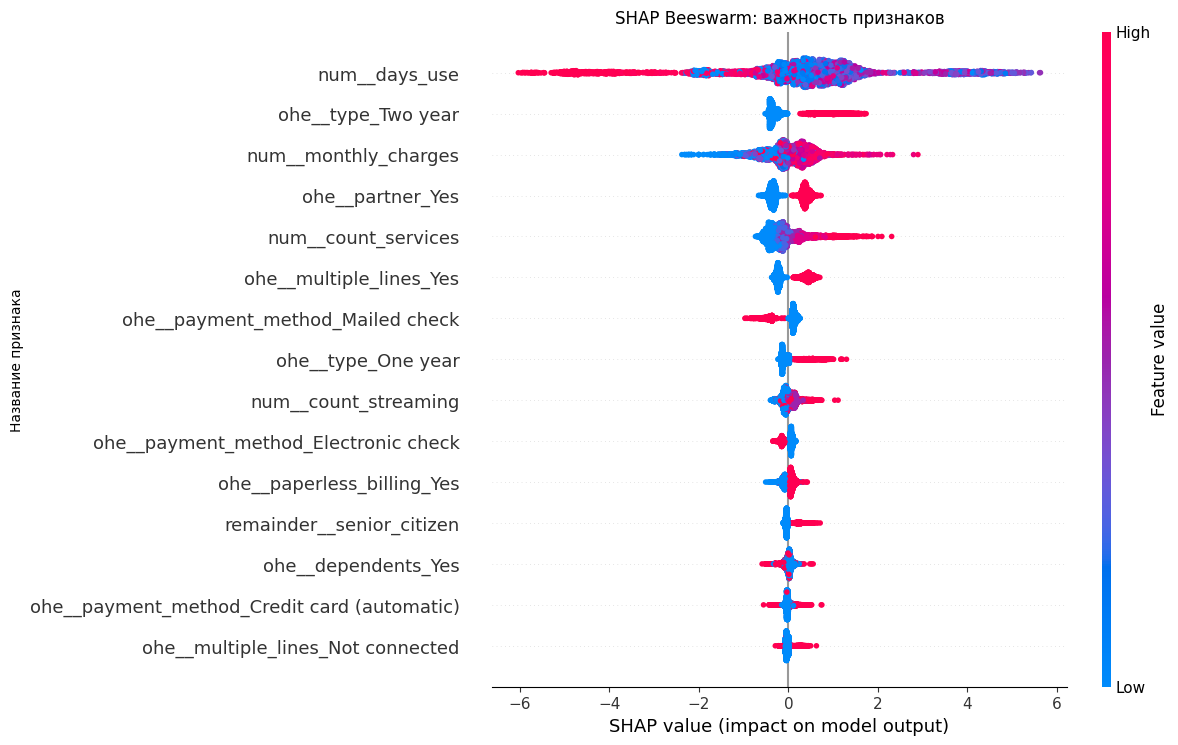

In [94]:
plt.ylabel("Название признака")
plt.title("SHAP Beeswarm: важность признаков")
plt.tight_layout()
shap.plots.beeswarm(shap_values, max_display=20)


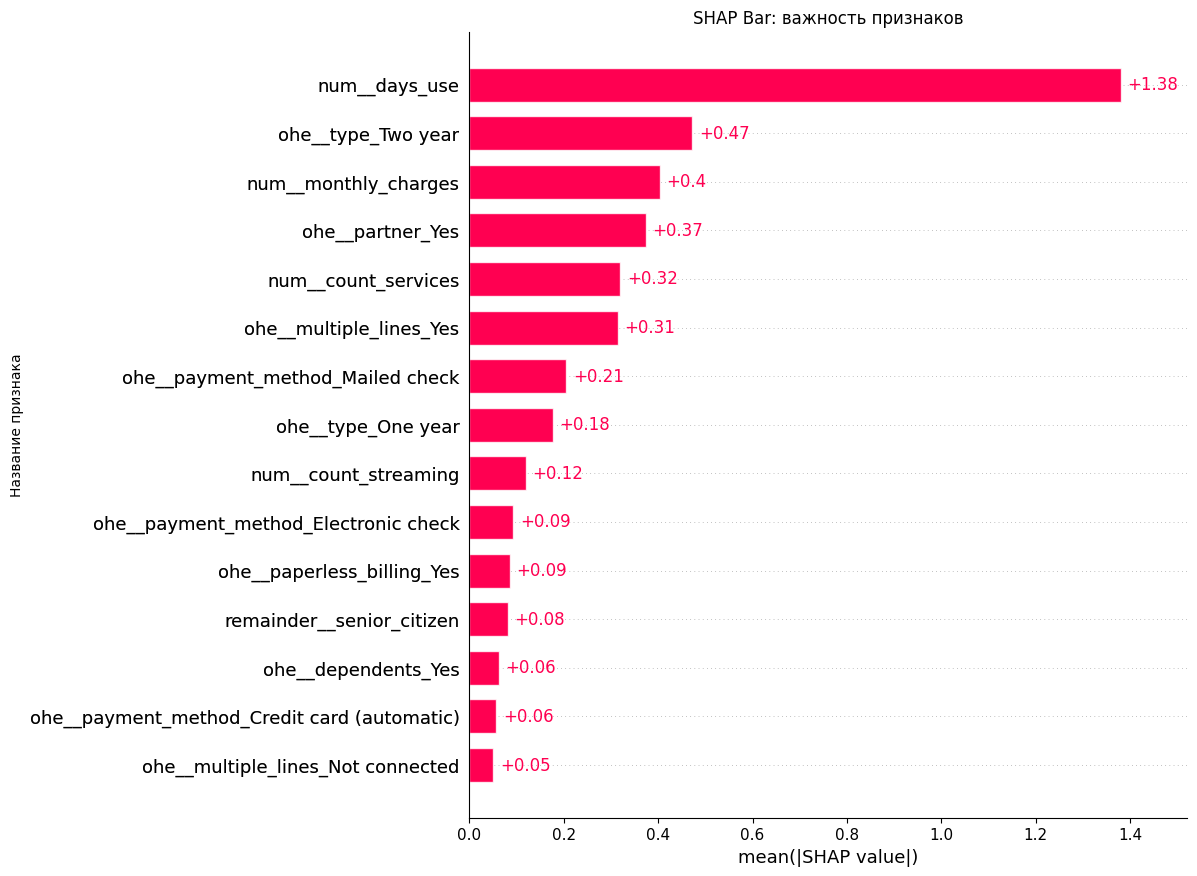

In [95]:
plt.ylabel("Название признака")
plt.title("SHAP Bar: важность признаков")
plt.tight_layout()
shap.plots.bar(shap_values, max_display=20)

___
    Выводы важности признаков

    Сильнее всего влияют на целевой признак:
    1. Кол-во дней, которые клиент уже работает с компанией
    2. Клиент оплачивает единожды в 2 года
    3. Сколько стоит ежемесячная оплата
    4. Клиент имеет партнера

    Признаки мало значимы для модели:
    1. Не подключен телефон к нескольким линиям одновременно
    2. Метод оплата - автоматически картой
    3. У клиента есть дети

    Чем больше услуг использует клиент, тем выше его лояльность и меньше риск, что клиент уйдет
    Наиболее важным является, что клиент уже долго работает с компанией
    Поэтому риск ухода нового клиента намного выше, чем риск ухода давнего клиента
    Также, если клиент оплачивает услуги надолго вперед, то меньше шанс, что он уйдет от компании
___

___
    Визуализируем матрицу ошибок модели
    Проанализируем и проведём ее интерпретацию 
___

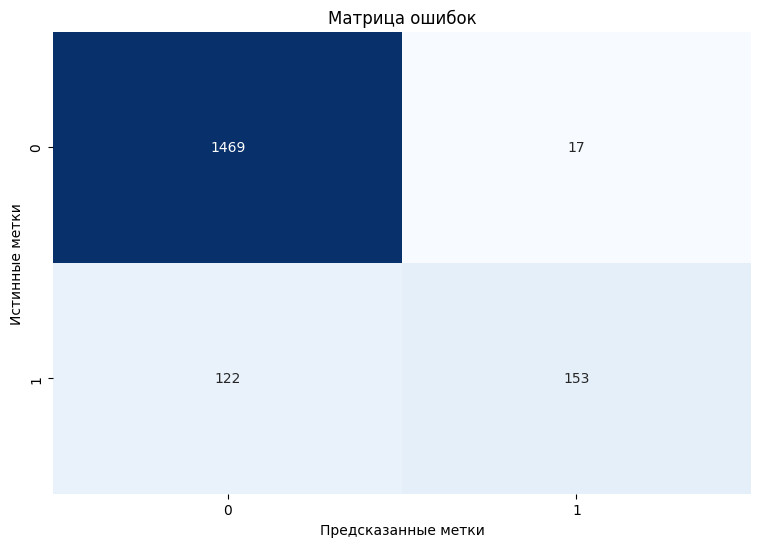

In [96]:
y_test_pred_labels = (y_test_pred >= 0.5).astype(int)
cm = confusion_matrix(y_test, y_test_pred_labels)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Предсказанные метки')
plt.ylabel('Истинные метки')
plt.title('Матрица ошибок')
plt.show()

___
    Выводы по матрице ошибок

    Среди 275 ушедших клиентов, модель верно определила, 
    что уйдут 153 клиентов, но не смогла определить ещё 122 клиента   

    Среди 1486 лояльных клиентов, модель верно оценила 1469 из них
    Но 17 оценила, как с риском ухода

    Под нужды бизнеса, матрицу ошибок можно корректировать с помощью порогом вероятности
    Можно сделать так, чтобы модель находила как можно больше пользователей, которые решают уйти, но ещё больше лояльных пользователей также будут классифицированы, как имеющие риск - уйти
    А если удерживать пользователя дорого - можно сосредоточиться на лояльных клиентах и настроить модель, чтобы она правильно классифицировала их, но меньше находила с риском уйти
___

## Общий вывод

___
**Вывод**

    Были выполнены задачи:
    1. Загрузили и предобработали данные, проверили на наличие пропусков и ошибок.
    2. Объединили данные.
    3. Провели исследовательский анализ данных.
    4. Создали новые признаки
    5. Провели корреляционный анализ
    6. Подготовили данные для обучения модели.
    7. Обучили модели машинного обучения
    8. Выбрали лучшую модель 
    9. Провели анализ важности признаков и матрицы ошибок

    Была выбрана лучшая модель с параметрами:  
    CatBoostClassifier
    {
        'preprocessor__num': StandardScaler(), 'models__subsample': 0.8, 
        'models__random_strength': 5, 'models__n_estimators': 1600, 
        'models__learning_rate': 0.05, 'models__l2_leaf_reg': 5, 
        'models__depth': 4, 'models__border_count': 128
    }
    Метрика ROC-AUC на тестовой выборке: 0.926
    Метрика Accuracy на тестовой выборке: 0.921   
    Это означает, что точность предсказания равна 92.1%

    Было выявлено, что сильнее всего влияет на целевой признак:
    1. Кол-во дней, которые клиент уже работает с компанией
    2. Клиент оплачивает единожды в 2 года
    3. Сколько стоит ежемесячная оплата
    4. Клиент имеет партнера

    Признаки мало значимы для модели:
    1. Не подключен телефон к нескольким линиям одновременно
    2. Метод оплата - автоматически картой
    3. У клиента есть дети

    Чем больше услуг использует клиент, тем выше его лояльность и меньше риск, что клиент уйдет
    Наиболее важным является, что клиент уже долго работает с компанией
    Поэтому риск ухода нового клиента намного выше, чем риск ухода давнего клиента
    Также, если клиент оплачивает услуги надолго вперед, то меньше шанс, что он уйдет от компании

    По матрице ошибок:
    Среди 275 ушедших клиентов, модель верно определила, 
    что уйдут 153 клиентов, но не смогла определить ещё 122 клиента   

    Среди 1486 лояльных клиентов, модель верно оценила 1469 из них
    Но 17 оценила, как с риском ухода

    На результаты модели можно ориентироваться для предсказания клиентов с риском ухода
    Для компании важно сфокусироваться на новых клиентах, т.к. они чаще находятся в группе риска
    Возможно, предлагать им больше услуг. Т.к. чем больше услуг подключено у клиента, тем более стабильным он считается
    Также, более стабильными считаются клиенты с оплатой раз в 2 года. Поэтому, важно предлагаться этот вариант оплаты
    
___